#### Для корректной работы нужно
* переместить файлы test.csv & train.csv в директорию data/
* скачать [graphviz](http://www.graphviz.org/download)  
* вылетает ошибка [“dot.exe” not found in path](https://stackoverflow.com/questions/40632486/dot-exe-not-found-in-path-pydot-on-python-windows-7)

In [1]:
import pandas as pd
import sys
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, roc_auc_score,precision_score,accuracy_score,roc_curve,make_scorer
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 

In [2]:
train = pd.read_csv('data/train.csv')
train.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,total_acc,initial_list_status,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,record_id
0,15000.0,36 months,11.99,498.15,B,B3,Quality Assurance Specialist,4 years,MORTGAGE,70000.0,...,32.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,295215.0,20500.0,453246940
1,3725.0,36 months,6.03,113.38,A,A1,NaN,NaN,MORTGAGE,52260.0,...,9.0,f,0.0,1.0,INDIVIDUAL,0.0,0.0,25130.0,14200.0,453313687
2,16000.0,36 months,11.14,524.89,B,B2,KIPP NYC,3 years,RENT,67500.0,...,22.0,f,0.0,1.0,INDIVIDUAL,0.0,193.0,41737.0,19448.0,453283543
3,4200.0,36 months,13.33,142.19,C,C3,Receptionist,< 1 year,MORTGAGE,21600.0,...,19.0,w,0.0,1.0,INDIVIDUAL,0.0,165.0,28187.0,14500.0,453447199
4,6500.0,36 months,12.69,218.05,B,B5,Medtox Laboratories,10+ years,RENT,41000.0,...,12.0,f,0.0,1.0,INDIVIDUAL,0.0,NaN,NaN,NaN,453350283


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 36 columns):
loan_amnt                     200189 non-null float64
term                          200189 non-null object
int_rate                      200189 non-null float64
installment                   200189 non-null float64
grade                         200189 non-null object
sub_grade                     200189 non-null object
emp_title                     189062 non-null object
emp_length                    192135 non-null object
home_ownership                200189 non-null object
annual_inc                    200189 non-null float64
verification_status           200189 non-null object
issue_d                       200189 non-null object
loan_status                   200189 non-null int64
pymnt_plan                    200189 non-null object
purpose                       200189 non-null object
zip_code                      200189 non-null object
addr_state                    200189 n

* int_rate - Interest Rate on the loan
* annual_inc - Theannual income provided by the borrower during registration
* inq_last_6mths -The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
* mths_since_last_delinq  - Months since most recent personal finance delinquency.
* pub_rec  - Number of derogatory public records
* revolBal - Total credit revolving balance
* revolUtil - Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
* loan_amnt  - The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
* installment - The monthly payment owed by the borrower if the loan originates.
* home_ownership    
* emp_title                   
* annual_inc                  
* verification_status  - Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified
* purpose                 
* dti -  A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
* open_acc                  
* total_acc                    
* initial_list_status - The initial listing status of the loan. Possible values are – W, F           
* collections_12_mths_ex_med - Number of collections in 12 months excluding medical collections
* application_type - Indicates whether the loan is an individual application or a joint application with two co-borrowers
* acc_now_delinq - The number of accounts on which the borrower is now delinquent.


## Начальная обработка данных:

In [103]:
def Nan_killer(x):
   # x['collections_12_mths_ex_med'] = x['collections_12_mths_ex_med'].fillna(0)
    categorical_features_names = x_train.columns[x_train.dtypes == 'object']
    if 'revol_utl' in categorical_features_names:
        x['revol_util'] = x['revol_util'].fillna(-999)
    if 'tot_coll_amt' in categorical_features_names:
        x['tot_coll_amt'] = x['tot_coll_amt'].fillna(-999)
    if 'tot_cur_bal' in categorical_features_names:
        x['tot_cur_bal'] =  x['tot_cur_bal'].fillna(-999)
    if 'total_rev_hi_lim' in categorical_features_names:
         x['total_rev_hi_lim'] =  x['total_rev_hi_lim'].fillna(-999)

In [5]:
def proc(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
    x_train['initial_list_status'] = x_train['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
    x_train['application_type'] = x_train['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
    x_test['initial_list_status'] = x_test['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
    x_test['application_type'] = x_test['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
    x_train = pd.get_dummies(x_train, columns = ['purpose','grade','home_ownership'])   # OHE (?????)
    x_test = pd.get_dummies(x_test, columns = ['purpose','grade','home_ownership'])
    for i in list(x_test): # удаление из тестовых данных столбцов, если их не было в тренировочных
        if i not in list(x_train):
            list(my_dataframe)
            x_test.drop(i, axis=1, inplace=True)
    for i in list(x_train): # добавление колонки с нулями, если такой нет в тестовой
        if i not in list(x_test):
            x_test[i] = 0
    

    x_test = x_test.reindex(sorted(x_test.columns), axis=1)
    x_train = x_train.reindex(sorted(x_test.columns), axis=1)
    return x_train, x_test, y_train, y_test

## Функция для отображения метрик:
* ROC-AUC
* precision
* recall
* accuracy

In [6]:

def show_scores(model, x_test, y_test):
    pred =  model.predict(x_test)
    print('Recall: %.2f' % recall_score(y_test,pred))
    print('Precision score: %.2f' % precision_score(y_test,pred))
    print('Accuracy score: %.2f' % accuracy_score(y_test, pred))
 

In [7]:
def plot_roc(model, x_test, y_test):  
    pred = model.predict_proba(x_test)
    print("ROC-AUC score: ", roc_auc_score(y_test, pred[:, 1]))
    fpr, tpr,_=roc_curve(y_test,pred[:, 1],drop_intermediate=True)
    plt.figure()
    plt.plot(fpr, tpr, color='red',
            lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()

# Регрессия

In [38]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

In [191]:
y = train[train['int_rate'] >= 0]['int_rate'] # целевой признак
x = train.loc[:,['annual_inc','collections_12_mths_ex_med','initial_list_status',
                 'installment','open_acc','total_acc','dti','purpose',
                 'grade','home_ownership','inq_last_6mths','pub_rec','revol_bal','revol_util','loan_status',
                 'tot_coll_amt','loan_amnt','application_type','acc_now_delinq' ] ] # параметры
x.info()

In [195]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 15 columns):
annual_inc             200189 non-null float64
initial_list_status    200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
grade                  200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
loan_status            200189 non-null int64
tot_coll_amt           200189 non-null float64
loan_amnt              200189 non-null float64
dtypes: float64(10), int64(1), object(4)
memory usage: 22.9+ MB


In [196]:
x.nunique()

annual_inc             16284
initial_list_status        2
installment            41347
open_acc                  58
total_acc                105
dti                     3975
purpose                   14
grade                      7
home_ownership             6
inq_last_6mths             9
revol_bal              44045
revol_util              1180
loan_status                2
tot_coll_amt            3646
loan_amnt               1317
dtype: int64

In [42]:
x_train, x_test, y_train, y_test = proc(x,y)

In [43]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 43 columns):
acc_now_delinq                140132 non-null float64
annual_inc                    140132 non-null float64
application_type              140132 non-null int64
collections_12_mths_ex_med    140132 non-null float64
dti                           140132 non-null float64
grade_A                       140132 non-null uint8
grade_B                       140132 non-null uint8
grade_C                       140132 non-null uint8
grade_D                       140132 non-null uint8
grade_E                       140132 non-null uint8
grade_F                       140132 non-null uint8
grade_G                       140132 non-null uint8
home_ownership_ANY            140132 non-null uint8
home_ownership_MORTGAGE       140132 non-null uint8
home_ownership_NONE           140132 non-null uint8
home_ownership_OTHER          140132 non-null uint8
home_ownership_OWN            140132 non-nul

In [44]:
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60057 entries, 8644 to 191094
Data columns (total 43 columns):
acc_now_delinq                60057 non-null float64
annual_inc                    60057 non-null float64
application_type              60057 non-null int64
collections_12_mths_ex_med    60057 non-null float64
dti                           60057 non-null float64
grade_A                       60057 non-null uint8
grade_B                       60057 non-null uint8
grade_C                       60057 non-null uint8
grade_D                       60057 non-null uint8
grade_E                       60057 non-null uint8
grade_F                       60057 non-null uint8
grade_G                       60057 non-null uint8
home_ownership_ANY            60057 non-null int64
home_ownership_MORTGAGE       60057 non-null uint8
home_ownership_NONE           60057 non-null uint8
home_ownership_OTHER          60057 non-null uint8
home_ownership_OWN            60057 non-null uint8
home_ownersh

## Линейная регрессия  + Дерево решений (регрессия)

In [15]:
lm = linear_model.Lasso(alpha=0.01,random_state = 42).fit(x_train,y_train)
dec_reg = DecisionTreeRegressor(criterion='mse',max_depth=10, random_state=42, min_samples_leaf = 3).fit(x_train,y_train)

In [16]:
from sklearn.metrics import r2_score

In [17]:
r2_score(y_test, lm.predict(x_test))

0.9146765103292894

In [18]:
r2_score(y_test, dec_reg.predict(x_test))

0.9280174951473175

# Бинарная классификация

In [59]:
y = train['loan_status'] # целевой признак
x = train.loc[:,['annual_inc','verification_status','int_rate','initial_list_status','term',
                 'installment','open_acc','total_acc','dti','purpose','tot_cur_bal',
                 'sub_grade','home_ownership','inq_last_6mths','total_rev_hi_lim',
                 'revol_bal','revol_util',
                 'tot_coll_amt','loan_amnt',] ] # параметры
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [60]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            200189 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200189 non-null float64
tot_coll_amt           200189 non-null float64
loan_amnt              200189 non-null float64
dt

In [61]:
# x_train, x_test, y_train, y_test = proc(x,y)

In [ ]:
x_train.info()

In [12]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 43 columns):
acc_now_delinq                140132 non-null float64
annual_inc                    140132 non-null float64
application_type              140132 non-null bool
collections_12_mths_ex_med    140132 non-null float64
dti                           140132 non-null float64
grade_A                       140132 non-null uint8
grade_B                       140132 non-null uint8
grade_C                       140132 non-null uint8
grade_D                       140132 non-null uint8
grade_E                       140132 non-null uint8
grade_F                       140132 non-null uint8
grade_G                       140132 non-null uint8
home_ownership_ANY            140132 non-null uint8
home_ownership_MORTGAGE       140132 non-null uint8
home_ownership_NONE           140132 non-null uint8
home_ownership_OTHER          140132 non-null uint8
home_ownership_OWN            140132 non-null

## Логистическая регрессия

In [24]:
from sklearn import linear_model

In [25]:
lr = linear_model.LogisticRegression(solver='liblinear',random_state=42).fit(x_train, y_train)
lr.predict(x_test)
show_scores(lr, x_test, y_test)

Recall: 1.00
Precision score: 0.78
Accuracy score: 0.78


ROC-AUC score:  0.5877202844814491


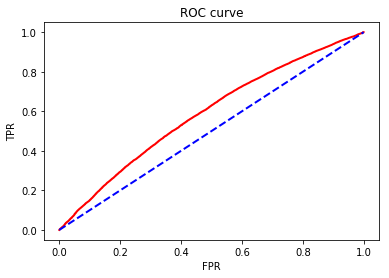

In [26]:
plot_roc(lr, x_test, y_test)

## Дерево решений (классификация)

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
clf_tree = DecisionTreeClassifier(criterion='entropy',splitter = 'random', max_depth=12, random_state=42, min_samples_leaf = 3)
clf_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random')

In [29]:
show_scores(clf_tree, x_test, y_test)

Recall: 0.97
Precision score: 0.79
Accuracy score: 0.77


ROC-AUC score:  0.6742598095246735


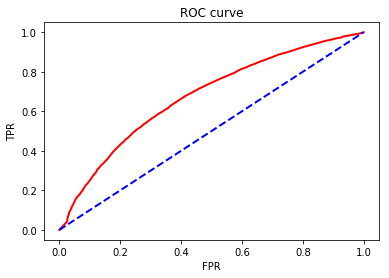

In [30]:
plot_roc(clf_tree, x_test, y_test)

## Случайный лес

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [32]:
#param_grid = {
#    'bootstrap': [True],
#    'max_depth': [12,10,8],
#    'min_samples_leaf': [1,3,5,7],
#    'n_estimators': [80,100,200,500],
#    'criterion' : ['entropy','gini'],
#}
#score = make_scorer(roc_auc_score)
#rf =  RandomForestClassifier(random_state = 42)
#grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                          cv = 5, n_jobs = -1, verbose = 2, scoring=score)
#grid_search.fit(x_train,  y_train)
#grid_search.best_params_
# best_grid = grid_search.best_estimator_

In [33]:
best_grid = RandomForestClassifier(random_state = 42, bootstrap = True, 
                                   max_depth = 12, min_samples_leaf = 1,
                                   n_estimators = 80, criterion = 'entropy')
best_grid.fit(x_train,  y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [34]:
best_grid.predict(x_test)
show_scores(best_grid, x_test, y_test)

Recall: 0.99
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7019092486975207


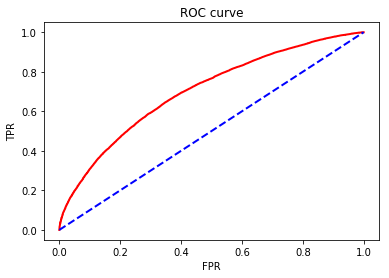

In [35]:
plot_roc(best_grid, x_test, y_test)

## VotingClassifier

In [36]:
from sklearn.ensemble import VotingClassifier

In [37]:
voting_clf = VotingClassifier(estimators=[('lr', lr), ('rf', best_grid)],voting='soft')
voting_clf.fit(x_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...mators=80, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [38]:
show_scores(voting_clf, x_test, y_test)

Recall: 1.00
Precision score: 0.78
Accuracy score: 0.78


ROC-AUC score:  0.6850833952966429


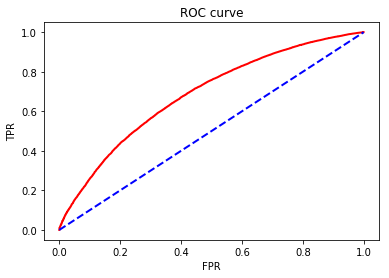

In [ ]:
plot_roc(voting_clf, x_test, y_test)

## Xgboost (Grid search)

[Параметры XGBClassifier](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [8]:
import xgboost as xgb

In [42]:
xgbst = xgb.XGBClassifier(
                           max_depth=3,
                           min_child_weight=3, #Defines the minimum sum of weights of all observations required
                           gamma = 0.25, 
                                    #A node is split only when the resulting split gives a positive 
                                    #reduction in the loss function. Gamma specifies the minimum loss 
                                    #reduction required to make a split.in a child
                           eval_metric = 'auc',                         
                           subsample= 0.52,
                                    #Denotes the fraction of observations to be randomly sampled for each tree
                           colsample_bytree=0.95, #The number of features to consider while searching for the best split
                           reg_alpha= 5,# L1 regularization term on weights
                           reg_lambda=0,# L2 regularization term on weights.
                           learning_rate = 0.01,
                           n_estimators =4000,
                           objective='binary:logistic',
                           
                           verbosity  = 2, # Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug). 
                          
                           scale_pos_weight=1, #Control the balance of positive and negative weights, useful for unbalanced classes
                           seed=20,
                           random_state= 42,
                           missing=None)

In [ ]:
xgbst.fit(x_train, y_train)

In [ ]:
show_scores(xgbst, x_train, y_train)

In [ ]:
show_scores(xgbst, x_test, y_test)

In [ ]:
plot_roc(xgbst, x_train, y_train)

In [ ]:
plot_roc(xgbst, x_test, y_test)

## Xgboost (Hypetopt)

In [13]:
from sklearn.metrics import r2_score
from hyperopt import tpe, hp, fmin
import xgboost as xgb
from hyperopt.mongoexp import MongoTrials

In [14]:
def func(args):
    loss = 0
    if args['model'] == xgb.XGBClassifier:
        max_depth = args['param']['max_depth']
        min_child_weight = args['param']['min_child_weight']
        gamma = args['param']['gamma']
        subsample = args['param']['subsample']
        colsample_bytree = args['param']['colsample_bytree']
        reg_alpha = args['param']['reg_alpha']
        clf = xgb.XGBClassifier(eval_metric = 'auc',
                               objective='binary:logistic',
                               verbosity  = 2,
                               random_state= 42,
                               learning_rate = 0.1,
                               n_estimators=1000,    
                               reg_lambda=0,
                               max_depth = max_depth,
                               min_child_weight =min_child_weight,
                               gamma =  gamma,
                               subsample = subsample,
                               colsample_bytree = colsample_bytree,
                               reg_alpha = reg_alpha)
        clf.fit(x_train,y_train)
        y_pred_train = clf.predict_proba(x_train)
        loss =  roc_auc_score(y_train, y_pred_train[:, 1])
        print("Test Score:",clf.score(x_test,y_test))
        print("Train Score:",clf.score(x_train,y_train))
        print("\n=================")
    return -loss


In [14]:
space = hp.choice('classifier',[
        {
        'model': xgb.XGBClassifier,
        'param': {
        'max_depth' : hp.choice('max_depth',range(3,10,2)),
        'min_child_weight' : hp.choice('min_child_weight', range(1,6,2)),
        'gamma' : hp.choice('gamma', [i/10.0 for i in range(0,5)]),
        'subsample' : hp.choice('subsample', [i/10.0 for i in range(6,10)]),
        'colsample_bytree'  : hp.choice('colsample_bytree', [i/10.0 for i in range(6,10)]),
        'reg_alpha' : hp.choice('reg_alpha', [1e-5, 1e-2, 0.1, 1, 100])  
        }}
        ])
space

In [16]:
# trials = MongoTrials('mongo://localhost:27017/foo_db/jobs',exp_key='exp1')

In [15]:
# best = fmin(func,space,algo=tpe.suggest,max_evals=100)
best = {'classifier': 0,
 'colsample_bytree': 1,
 'gamma': 1,
 'max_depth': 3,
 'min_child_weight': 0,
 'reg_alpha': 3,
 'subsample': 0}

In [16]:
best

{'classifier': 0,
 'colsample_bytree': 1,
 'gamma': 1,
 'max_depth': 3,
 'min_child_weight': 0,
 'reg_alpha': 3,
 'subsample': 0}

In [25]:
bst = xgb.XGBClassifier(     eval_metric = 'auc',
                               objective='binary:logistic',
                               verbosity  = 2,
                               random_state= 42,
                               learning_rate = 0.01,
                               n_estimators=4000,    
                               reg_lambda=0,
                               seed = 20,
                               max_depth = best['max_depth'],
                               min_child_weight = best['min_child_weight'],
                               gamma =  best['gamma'],
                               subsample = 0.52,
                               colsample_bytree = best['colsample_bytree'],
                               reg_alpha = best['reg_alpha'])

In [26]:
bst.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=1, learning_rate=0.01,
       max_delta_step=0, max_depth=3, min_child_weight=0, missing=None,
       n_estimators=4000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=3,
       reg_lambda=0, scale_pos_weight=1, seed=20, silent=True,
       subsample=0.52, verbosity=2)

In [34]:
show_scores(bst, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.7115789901232025


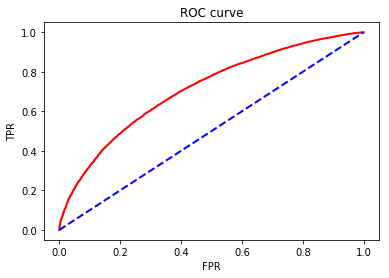

In [35]:
plot_roc(bst, x_test, y_test)

## Catboost

In [62]:
from hyperopt import tpe, hp, fmin
import hyperopt 

In [63]:
x['purpose'].value_counts()

debt_consolidation    117953
credit_card            39337
home_improvement       11855
other                  11304
major_purchase          4865
small_business          3757
car                     2813
medical                 2273
moving                  1645
wedding                 1451
house                   1272
vacation                1220
educational              244
renewable_energy         200
Name: purpose, dtype: int64

In [64]:
x['purpose'] = x['purpose'].astype(str).map(lambda x: 'other' if x in ['credit_card','home_improvement','educational', 'renewable_energy','vacation','house','wedding','moving','medical','car','small_business','major_purchase'] else x)

In [65]:
x['purpose'].value_counts()

debt_consolidation    117953
other                  82236
Name: purpose, dtype: int64

In [66]:
x['term'].value_counts()

 36 months    153900
 60 months     46289
Name: term, dtype: int64

In [67]:
x['term'] = x['term'].astype(str).map(lambda x: 36 if x == ' 36 months' else 60)

In [68]:
x['term'].value_counts()

36    153900
60     46289
Name: term, dtype: int64

In [69]:
x['home_ownership'].value_counts()

MORTGAGE    98279
RENT        84233
OWN         17542
OTHER         101
NONE           33
ANY             1
Name: home_ownership, dtype: int64

In [70]:
x['home_ownership'] = x['home_ownership'].astype(str).map(lambda x: 'OTHER' if x in ['NONE', 'ANY'] else x)

In [71]:
x['home_ownership'].value_counts()

MORTGAGE    98279
RENT        84233
OWN         17542
OTHER         135
Name: home_ownership, dtype: int64

In [72]:
x['home_ownership'] = x['home_ownership'].astype(str).map(lambda x: 'OTHER' if x in ['NONE', 'ANY'] else x)

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
# x_train['initial_list_status'] = x_train['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
# x_test['initial_list_status'] = x_test['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_test['sub_grade'] = x_test['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
x_train['sub_grade'] = x_train['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))
# x_train = pd.get_dummies(x_train, columns = ['purpose','home_ownership'])   # OHE (?????)
# x_test = pd.get_dummies(x_test, columns = ['purpose','home_ownership'])
#for i in list(x_test): # удаление из тестовых данных столбцов, если их не было в тренировочных
#    if i not in list(x_train):
#        list(my_dataframe)
#        x_test.drop(i, axis=1, inplace=True)
#for i in list(x_train): # добавление колонки с нулями, если такой нет в тестовой
#    if i not in list(x_test):
#         x_test[i] = 0   

#x_test = x_test.reindex(sorted(x_test.columns), axis=1)
#x_train = x_train.reindex(sorted(x_test.columns), axis=1)

In [74]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 19 columns):
annual_inc             140132 non-null float64
verification_status    140132 non-null object
int_rate               140132 non-null float64
initial_list_status    140132 non-null object
term                   140132 non-null int64
installment            140132 non-null float64
open_acc               140132 non-null float64
total_acc              140132 non-null float64
dti                    140132 non-null float64
purpose                140132 non-null object
tot_cur_bal            140132 non-null float64
sub_grade              140132 non-null int64
home_ownership         140132 non-null object
inq_last_6mths         140132 non-null float64
total_rev_hi_lim       106404 non-null float64
revol_bal              140132 non-null float64
revol_util             140132 non-null float64
tot_coll_amt           140132 non-null float64
loan_amnt              140132 non-null float64

In [75]:
x_train.head()

,annual_inc,verification_status,int_rate,initial_list_status,term,installment,open_acc,total_acc,dti,purpose,tot_cur_bal,sub_grade,home_ownership,inq_last_6mths,total_rev_hi_lim,revol_bal,revol_util,tot_coll_amt,loan_amnt
193136,75000.0,Source Verified,13.11,w,36,690.97,17.0,42.0,26.85,other,223010.0,664,MORTGAGE,2.0,43599.0,38230.0,87.7,0.0,20475.0
27784,73000.0,Verified,15.99,f,36,421.83,18.0,38.0,16.47,debt_consolidation,230520.0,682,MORTGAGE,2.0,24100.0,9874.0,41.0,0.0,12000.0
157132,200000.0,Verified,8.90,f,36,508.06,14.0,37.0,13.50,debt_consolidation,488248.0,655,MORTGAGE,2.0,54800.0,34550.0,63.0,0.0,16000.0
81962,100000.0,Not Verified,15.33,f,36,417.94,17.0,36.0,20.48,debt_consolidation,-999.0,683,MORTGAGE,3.0,NaN,88599.0,60.9,-999.0,12000.0
161,65000.0,Verified,14.16,w,36,342.56,14.0,19.0,14.00,debt_consolidation,18270.0,672,RENT,2.0,25100.0,10948.0,43.6,0.0,10000.0


In [76]:
categorical_features_names = x_train.columns[x_train.dtypes == 'object']
categorical_features_names

Index(['verification_status', 'initial_list_status', 'purpose',
       'home_ownership'],
      dtype='object')

In [77]:
categorical_features_indices = [x_train.columns.get_loc(i) for i in categorical_features_names]
categorical_features_indices

[1, 3, 9, 12]

In [78]:
from catboost import CatBoostClassifier, Pool, cv
import catboost as cb
import frozendict
# roc_auc_score

In [79]:
params = {'learning_rate': 0.01,
          'depth': 9.0,
        #  'rsm': 0.8789580279825991,
          'l2_leaf_reg': 29.083288170330242,
          'task_type': 'CPU',
          'loss_function': 'Logloss',
          'eval_metric': 'AUC', 'od_type': 'Iter',
          'od_wait': 40,
          'custom_metric': ['AUC'],
          'iterations': 4000,
          'random_seed': 42}
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(x_test, y_test, cat_features=categorical_features_indices)


In [80]:
best_model_params = params.copy()
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

0:	test: 0.6868615	best: 0.6868615 (0)	total: 206ms	remaining: 13m 44s
1:	test: 0.6905013	best: 0.6905013 (1)	total: 407ms	remaining: 13m 33s
2:	test: 0.6933194	best: 0.6933194 (2)	total: 634ms	remaining: 14m 4s
3:	test: 0.6939173	best: 0.6939173 (3)	total: 840ms	remaining: 13m 59s
4:	test: 0.6948312	best: 0.6948312 (4)	total: 1.04s	remaining: 13m 50s
5:	test: 0.6956751	best: 0.6956751 (5)	total: 1.25s	remaining: 13m 50s
6:	test: 0.6959766	best: 0.6959766 (6)	total: 1.47s	remaining: 13m 58s
7:	test: 0.6965321	best: 0.6965321 (7)	total: 1.69s	remaining: 14m 3s
8:	test: 0.6973244	best: 0.6973244 (8)	total: 1.93s	remaining: 14m 16s
9:	test: 0.6979112	best: 0.6979112 (9)	total: 2.19s	remaining: 14m 33s
10:	test: 0.6983373	best: 0.6983373 (10)	total: 2.41s	remaining: 14m 35s
11:	test: 0.6983415	best: 0.6983415 (11)	total: 2.6s	remaining: 14m 25s
12:	test: 0.6983272	best: 0.6983415 (11)	total: 2.81s	remaining: 14m 20s
13:	test: 0.6981894	best: 0.6983415 (11)	total: 3.02s	remaining: 14m 18s
1

113:	test: 0.7027473	best: 0.7027473 (113)	total: 22.4s	remaining: 12m 42s
114:	test: 0.7028315	best: 0.7028315 (114)	total: 22.6s	remaining: 12m 42s
115:	test: 0.7028610	best: 0.7028610 (115)	total: 22.8s	remaining: 12m 43s
116:	test: 0.7029002	best: 0.7029002 (116)	total: 23s	remaining: 12m 44s
117:	test: 0.7028722	best: 0.7029002 (116)	total: 23.1s	remaining: 12m 41s
118:	test: 0.7029659	best: 0.7029659 (118)	total: 23.4s	remaining: 12m 41s
119:	test: 0.7030128	best: 0.7030128 (119)	total: 23.6s	remaining: 12m 41s
120:	test: 0.7030931	best: 0.7030931 (120)	total: 23.8s	remaining: 12m 42s
121:	test: 0.7031511	best: 0.7031511 (121)	total: 24s	remaining: 12m 42s
122:	test: 0.7031576	best: 0.7031576 (122)	total: 24.2s	remaining: 12m 42s
123:	test: 0.7032204	best: 0.7032204 (123)	total: 24.4s	remaining: 12m 43s
124:	test: 0.7032463	best: 0.7032463 (124)	total: 24.6s	remaining: 12m 43s
125:	test: 0.7032704	best: 0.7032704 (125)	total: 24.8s	remaining: 12m 43s
126:	test: 0.7033124	best: 0.

223:	test: 0.7065188	best: 0.7065188 (223)	total: 43.4s	remaining: 12m 11s
224:	test: 0.7065449	best: 0.7065449 (224)	total: 43.6s	remaining: 12m 11s
225:	test: 0.7065634	best: 0.7065634 (225)	total: 43.8s	remaining: 12m 11s
226:	test: 0.7066079	best: 0.7066079 (226)	total: 44s	remaining: 12m 11s
227:	test: 0.7066277	best: 0.7066277 (227)	total: 44.2s	remaining: 12m 11s
228:	test: 0.7066713	best: 0.7066713 (228)	total: 44.4s	remaining: 12m 11s
229:	test: 0.7067183	best: 0.7067183 (229)	total: 44.6s	remaining: 12m 11s
230:	test: 0.7067512	best: 0.7067512 (230)	total: 44.8s	remaining: 12m 11s
231:	test: 0.7067789	best: 0.7067789 (231)	total: 45s	remaining: 12m 10s
232:	test: 0.7068260	best: 0.7068260 (232)	total: 45.2s	remaining: 12m 10s
233:	test: 0.7068258	best: 0.7068260 (232)	total: 45.4s	remaining: 12m 10s
234:	test: 0.7068398	best: 0.7068398 (234)	total: 45.6s	remaining: 12m 10s
235:	test: 0.7068608	best: 0.7068608 (235)	total: 45.8s	remaining: 12m 10s
236:	test: 0.7068962	best: 0.

334:	test: 0.7088644	best: 0.7088644 (334)	total: 1m 5s	remaining: 11m 54s
335:	test: 0.7088770	best: 0.7088770 (335)	total: 1m 5s	remaining: 11m 54s
336:	test: 0.7089007	best: 0.7089007 (336)	total: 1m 5s	remaining: 11m 54s
337:	test: 0.7089089	best: 0.7089089 (337)	total: 1m 5s	remaining: 11m 54s
338:	test: 0.7089268	best: 0.7089268 (338)	total: 1m 6s	remaining: 11m 54s
339:	test: 0.7089519	best: 0.7089519 (339)	total: 1m 6s	remaining: 11m 54s
340:	test: 0.7089596	best: 0.7089596 (340)	total: 1m 6s	remaining: 11m 54s
341:	test: 0.7089766	best: 0.7089766 (341)	total: 1m 6s	remaining: 11m 54s
342:	test: 0.7089881	best: 0.7089881 (342)	total: 1m 6s	remaining: 11m 54s
343:	test: 0.7090093	best: 0.7090093 (343)	total: 1m 7s	remaining: 11m 54s
344:	test: 0.7090184	best: 0.7090184 (344)	total: 1m 7s	remaining: 11m 53s
345:	test: 0.7090227	best: 0.7090227 (345)	total: 1m 7s	remaining: 11m 53s
346:	test: 0.7090510	best: 0.7090510 (346)	total: 1m 7s	remaining: 11m 53s
347:	test: 0.7090575	best

443:	test: 0.7102387	best: 0.7102387 (443)	total: 1m 27s	remaining: 11m 41s
444:	test: 0.7102451	best: 0.7102451 (444)	total: 1m 27s	remaining: 11m 41s
445:	test: 0.7102577	best: 0.7102577 (445)	total: 1m 27s	remaining: 11m 41s
446:	test: 0.7102676	best: 0.7102676 (446)	total: 1m 28s	remaining: 11m 41s
447:	test: 0.7102732	best: 0.7102732 (447)	total: 1m 28s	remaining: 11m 40s
448:	test: 0.7102820	best: 0.7102820 (448)	total: 1m 28s	remaining: 11m 40s
449:	test: 0.7102917	best: 0.7102917 (449)	total: 1m 28s	remaining: 11m 40s
450:	test: 0.7103084	best: 0.7103084 (450)	total: 1m 28s	remaining: 11m 40s
451:	test: 0.7103173	best: 0.7103173 (451)	total: 1m 29s	remaining: 11m 40s
452:	test: 0.7103386	best: 0.7103386 (452)	total: 1m 29s	remaining: 11m 39s
453:	test: 0.7103470	best: 0.7103470 (453)	total: 1m 29s	remaining: 11m 39s
454:	test: 0.7103489	best: 0.7103489 (454)	total: 1m 29s	remaining: 11m 39s
455:	test: 0.7103567	best: 0.7103567 (455)	total: 1m 29s	remaining: 11m 39s
456:	test: 0

551:	test: 0.7111799	best: 0.7111799 (551)	total: 1m 49s	remaining: 11m 23s
552:	test: 0.7111783	best: 0.7111799 (551)	total: 1m 49s	remaining: 11m 23s
553:	test: 0.7111787	best: 0.7111799 (551)	total: 1m 49s	remaining: 11m 22s
554:	test: 0.7111827	best: 0.7111827 (554)	total: 1m 50s	remaining: 11m 22s
555:	test: 0.7111918	best: 0.7111918 (555)	total: 1m 50s	remaining: 11m 22s
556:	test: 0.7111957	best: 0.7111957 (556)	total: 1m 50s	remaining: 11m 22s
557:	test: 0.7112035	best: 0.7112035 (557)	total: 1m 50s	remaining: 11m 22s
558:	test: 0.7112074	best: 0.7112074 (558)	total: 1m 50s	remaining: 11m 22s
559:	test: 0.7112138	best: 0.7112138 (559)	total: 1m 51s	remaining: 11m 22s
560:	test: 0.7112181	best: 0.7112181 (560)	total: 1m 51s	remaining: 11m 21s
561:	test: 0.7112288	best: 0.7112288 (561)	total: 1m 51s	remaining: 11m 21s
562:	test: 0.7112317	best: 0.7112317 (562)	total: 1m 51s	remaining: 11m 21s
563:	test: 0.7112340	best: 0.7112340 (563)	total: 1m 51s	remaining: 11m 21s
564:	test: 0

661:	test: 0.7118644	best: 0.7118644 (661)	total: 2m 11s	remaining: 11m 3s
662:	test: 0.7118661	best: 0.7118661 (662)	total: 2m 11s	remaining: 11m 2s
663:	test: 0.7118731	best: 0.7118731 (663)	total: 2m 11s	remaining: 11m 2s
664:	test: 0.7118811	best: 0.7118811 (664)	total: 2m 12s	remaining: 11m 2s
665:	test: 0.7118868	best: 0.7118868 (665)	total: 2m 12s	remaining: 11m 2s
666:	test: 0.7118877	best: 0.7118877 (666)	total: 2m 12s	remaining: 11m 1s
667:	test: 0.7118933	best: 0.7118933 (667)	total: 2m 12s	remaining: 11m 1s
668:	test: 0.7119014	best: 0.7119014 (668)	total: 2m 12s	remaining: 11m 1s
669:	test: 0.7119067	best: 0.7119067 (669)	total: 2m 13s	remaining: 11m 1s
670:	test: 0.7119074	best: 0.7119074 (670)	total: 2m 13s	remaining: 11m
671:	test: 0.7119097	best: 0.7119097 (671)	total: 2m 13s	remaining: 11m
672:	test: 0.7119191	best: 0.7119191 (672)	total: 2m 13s	remaining: 11m
673:	test: 0.7119208	best: 0.7119208 (673)	total: 2m 13s	remaining: 11m
674:	test: 0.7119280	best: 0.7119280 

770:	test: 0.7123929	best: 0.7123929 (770)	total: 2m 32s	remaining: 10m 40s
771:	test: 0.7123983	best: 0.7123983 (771)	total: 2m 33s	remaining: 10m 40s
772:	test: 0.7124096	best: 0.7124096 (772)	total: 2m 33s	remaining: 10m 40s
773:	test: 0.7124090	best: 0.7124096 (772)	total: 2m 33s	remaining: 10m 40s
774:	test: 0.7124139	best: 0.7124139 (774)	total: 2m 33s	remaining: 10m 39s
775:	test: 0.7124214	best: 0.7124214 (775)	total: 2m 33s	remaining: 10m 39s
776:	test: 0.7124253	best: 0.7124253 (776)	total: 2m 34s	remaining: 10m 39s
777:	test: 0.7124287	best: 0.7124287 (777)	total: 2m 34s	remaining: 10m 39s
778:	test: 0.7124368	best: 0.7124368 (778)	total: 2m 34s	remaining: 10m 39s
779:	test: 0.7124321	best: 0.7124368 (778)	total: 2m 34s	remaining: 10m 38s
780:	test: 0.7124348	best: 0.7124368 (778)	total: 2m 34s	remaining: 10m 38s
781:	test: 0.7124406	best: 0.7124406 (781)	total: 2m 35s	remaining: 10m 38s
782:	test: 0.7124529	best: 0.7124529 (782)	total: 2m 35s	remaining: 10m 38s
783:	test: 0

878:	test: 0.7128032	best: 0.7128032 (878)	total: 2m 54s	remaining: 10m 19s
879:	test: 0.7128020	best: 0.7128032 (878)	total: 2m 54s	remaining: 10m 19s
880:	test: 0.7128041	best: 0.7128041 (880)	total: 2m 55s	remaining: 10m 19s
881:	test: 0.7128056	best: 0.7128056 (881)	total: 2m 55s	remaining: 10m 19s
882:	test: 0.7128052	best: 0.7128056 (881)	total: 2m 55s	remaining: 10m 19s
883:	test: 0.7128055	best: 0.7128056 (881)	total: 2m 55s	remaining: 10m 19s
884:	test: 0.7128045	best: 0.7128056 (881)	total: 2m 55s	remaining: 10m 19s
885:	test: 0.7128113	best: 0.7128113 (885)	total: 2m 56s	remaining: 10m 18s
886:	test: 0.7128189	best: 0.7128189 (886)	total: 2m 56s	remaining: 10m 18s
887:	test: 0.7128210	best: 0.7128210 (887)	total: 2m 56s	remaining: 10m 18s
888:	test: 0.7128306	best: 0.7128306 (888)	total: 2m 56s	remaining: 10m 18s
889:	test: 0.7128368	best: 0.7128368 (889)	total: 2m 56s	remaining: 10m 18s
890:	test: 0.7128380	best: 0.7128380 (890)	total: 2m 57s	remaining: 10m 17s
891:	test: 0

988:	test: 0.7131042	best: 0.7131054 (987)	total: 3m 17s	remaining: 10m 2s
989:	test: 0.7131010	best: 0.7131054 (987)	total: 3m 17s	remaining: 10m 1s
990:	test: 0.7131047	best: 0.7131054 (987)	total: 3m 18s	remaining: 10m 1s
991:	test: 0.7131060	best: 0.7131060 (991)	total: 3m 18s	remaining: 10m 1s
992:	test: 0.7131102	best: 0.7131102 (992)	total: 3m 18s	remaining: 10m 1s
993:	test: 0.7131153	best: 0.7131153 (993)	total: 3m 18s	remaining: 10m 1s
994:	test: 0.7131170	best: 0.7131170 (994)	total: 3m 19s	remaining: 10m 1s
995:	test: 0.7131176	best: 0.7131176 (995)	total: 3m 19s	remaining: 10m
996:	test: 0.7131188	best: 0.7131188 (996)	total: 3m 19s	remaining: 10m
997:	test: 0.7131280	best: 0.7131280 (997)	total: 3m 19s	remaining: 10m
998:	test: 0.7131287	best: 0.7131287 (998)	total: 3m 19s	remaining: 10m
999:	test: 0.7131298	best: 0.7131298 (999)	total: 3m 20s	remaining: 10m
1000:	test: 0.7131352	best: 0.7131352 (1000)	total: 3m 20s	remaining: 9m 59s
1001:	test: 0.7131414	best: 0.7131414 

1095:	test: 0.7133990	best: 0.7134018 (1093)	total: 3m 39s	remaining: 9m 41s
1096:	test: 0.7134010	best: 0.7134018 (1093)	total: 3m 39s	remaining: 9m 41s
1097:	test: 0.7134041	best: 0.7134041 (1097)	total: 3m 39s	remaining: 9m 40s
1098:	test: 0.7134030	best: 0.7134041 (1097)	total: 3m 39s	remaining: 9m 40s
1099:	test: 0.7133998	best: 0.7134041 (1097)	total: 3m 40s	remaining: 9m 40s
1100:	test: 0.7134002	best: 0.7134041 (1097)	total: 3m 40s	remaining: 9m 39s
1101:	test: 0.7134048	best: 0.7134048 (1101)	total: 3m 40s	remaining: 9m 39s
1102:	test: 0.7134071	best: 0.7134071 (1102)	total: 3m 40s	remaining: 9m 39s
1103:	test: 0.7134071	best: 0.7134071 (1102)	total: 3m 40s	remaining: 9m 39s
1104:	test: 0.7134093	best: 0.7134093 (1104)	total: 3m 41s	remaining: 9m 39s
1105:	test: 0.7134136	best: 0.7134136 (1105)	total: 3m 41s	remaining: 9m 38s
1106:	test: 0.7134105	best: 0.7134136 (1105)	total: 3m 41s	remaining: 9m 38s
1107:	test: 0.7134160	best: 0.7134160 (1107)	total: 3m 41s	remaining: 9m 38s

1202:	test: 0.7136226	best: 0.7136226 (1202)	total: 4m 1s	remaining: 9m 20s
1203:	test: 0.7136286	best: 0.7136286 (1203)	total: 4m 1s	remaining: 9m 20s
1204:	test: 0.7136354	best: 0.7136354 (1204)	total: 4m 1s	remaining: 9m 20s
1205:	test: 0.7136383	best: 0.7136383 (1205)	total: 4m 1s	remaining: 9m 19s
1206:	test: 0.7136361	best: 0.7136383 (1205)	total: 4m 1s	remaining: 9m 19s
1207:	test: 0.7136463	best: 0.7136463 (1207)	total: 4m 2s	remaining: 9m 19s
1208:	test: 0.7136526	best: 0.7136526 (1208)	total: 4m 2s	remaining: 9m 19s
1209:	test: 0.7136564	best: 0.7136564 (1209)	total: 4m 2s	remaining: 9m 19s
1210:	test: 0.7136586	best: 0.7136586 (1210)	total: 4m 2s	remaining: 9m 18s
1211:	test: 0.7136584	best: 0.7136586 (1210)	total: 4m 2s	remaining: 9m 18s
1212:	test: 0.7136574	best: 0.7136586 (1210)	total: 4m 3s	remaining: 9m 18s
1213:	test: 0.7136573	best: 0.7136586 (1210)	total: 4m 3s	remaining: 9m 18s
1214:	test: 0.7136602	best: 0.7136602 (1214)	total: 4m 3s	remaining: 9m 17s
1215:	test: 

1310:	test: 0.7138797	best: 0.7138797 (1310)	total: 4m 23s	remaining: 8m 59s
1311:	test: 0.7138806	best: 0.7138806 (1311)	total: 4m 23s	remaining: 8m 59s
1312:	test: 0.7138790	best: 0.7138806 (1311)	total: 4m 23s	remaining: 8m 59s
1313:	test: 0.7138766	best: 0.7138806 (1311)	total: 4m 23s	remaining: 8m 59s
1314:	test: 0.7138829	best: 0.7138829 (1314)	total: 4m 23s	remaining: 8m 58s
1315:	test: 0.7138881	best: 0.7138881 (1315)	total: 4m 24s	remaining: 8m 58s
1316:	test: 0.7138892	best: 0.7138892 (1316)	total: 4m 24s	remaining: 8m 58s
1317:	test: 0.7138915	best: 0.7138915 (1317)	total: 4m 24s	remaining: 8m 58s
1318:	test: 0.7138981	best: 0.7138981 (1318)	total: 4m 24s	remaining: 8m 58s
1319:	test: 0.7138983	best: 0.7138983 (1319)	total: 4m 24s	remaining: 8m 57s
1320:	test: 0.7139032	best: 0.7139032 (1320)	total: 4m 25s	remaining: 8m 57s
1321:	test: 0.7139005	best: 0.7139032 (1320)	total: 4m 25s	remaining: 8m 57s
1322:	test: 0.7138984	best: 0.7139032 (1320)	total: 4m 25s	remaining: 8m 57s

1417:	test: 0.7140359	best: 0.7140360 (1416)	total: 4m 44s	remaining: 8m 38s
1418:	test: 0.7140345	best: 0.7140360 (1416)	total: 4m 44s	remaining: 8m 38s
1419:	test: 0.7140331	best: 0.7140360 (1416)	total: 4m 45s	remaining: 8m 38s
1420:	test: 0.7140399	best: 0.7140399 (1420)	total: 4m 45s	remaining: 8m 37s
1421:	test: 0.7140385	best: 0.7140399 (1420)	total: 4m 45s	remaining: 8m 37s
1422:	test: 0.7140383	best: 0.7140399 (1420)	total: 4m 45s	remaining: 8m 37s
1423:	test: 0.7140431	best: 0.7140431 (1423)	total: 4m 45s	remaining: 8m 37s
1424:	test: 0.7140504	best: 0.7140504 (1424)	total: 4m 46s	remaining: 8m 37s
1425:	test: 0.7140543	best: 0.7140543 (1425)	total: 4m 46s	remaining: 8m 36s
1426:	test: 0.7140605	best: 0.7140605 (1426)	total: 4m 46s	remaining: 8m 36s
1427:	test: 0.7140609	best: 0.7140609 (1427)	total: 4m 46s	remaining: 8m 36s
1428:	test: 0.7140636	best: 0.7140636 (1428)	total: 4m 46s	remaining: 8m 36s
1429:	test: 0.7140680	best: 0.7140680 (1429)	total: 4m 47s	remaining: 8m 36s

1525:	test: 0.7142564	best: 0.7142583 (1524)	total: 5m 6s	remaining: 8m 17s
1526:	test: 0.7142608	best: 0.7142608 (1526)	total: 5m 7s	remaining: 8m 17s
1527:	test: 0.7142597	best: 0.7142608 (1526)	total: 5m 7s	remaining: 8m 17s
1528:	test: 0.7142627	best: 0.7142627 (1528)	total: 5m 7s	remaining: 8m 17s
1529:	test: 0.7142650	best: 0.7142650 (1529)	total: 5m 7s	remaining: 8m 16s
1530:	test: 0.7142703	best: 0.7142703 (1530)	total: 5m 8s	remaining: 8m 16s
1531:	test: 0.7142686	best: 0.7142703 (1530)	total: 5m 8s	remaining: 8m 16s
1532:	test: 0.7142691	best: 0.7142703 (1530)	total: 5m 8s	remaining: 8m 16s
1533:	test: 0.7142676	best: 0.7142703 (1530)	total: 5m 8s	remaining: 8m 16s
1534:	test: 0.7142675	best: 0.7142703 (1530)	total: 5m 8s	remaining: 8m 15s
1535:	test: 0.7142615	best: 0.7142703 (1530)	total: 5m 8s	remaining: 8m 15s
1536:	test: 0.7142604	best: 0.7142703 (1530)	total: 5m 9s	remaining: 8m 15s
1537:	test: 0.7142642	best: 0.7142703 (1530)	total: 5m 9s	remaining: 8m 15s
1538:	test: 

1633:	test: 0.7143235	best: 0.7143235 (1633)	total: 5m 29s	remaining: 7m 56s
1634:	test: 0.7143224	best: 0.7143235 (1633)	total: 5m 29s	remaining: 7m 56s
1635:	test: 0.7143233	best: 0.7143235 (1633)	total: 5m 29s	remaining: 7m 56s
1636:	test: 0.7143205	best: 0.7143235 (1633)	total: 5m 29s	remaining: 7m 56s
1637:	test: 0.7143202	best: 0.7143235 (1633)	total: 5m 30s	remaining: 7m 56s
1638:	test: 0.7143189	best: 0.7143235 (1633)	total: 5m 30s	remaining: 7m 55s
1639:	test: 0.7143182	best: 0.7143235 (1633)	total: 5m 30s	remaining: 7m 55s
1640:	test: 0.7143183	best: 0.7143235 (1633)	total: 5m 30s	remaining: 7m 55s
1641:	test: 0.7143239	best: 0.7143239 (1641)	total: 5m 31s	remaining: 7m 55s
1642:	test: 0.7143201	best: 0.7143239 (1641)	total: 5m 31s	remaining: 7m 55s
1643:	test: 0.7143249	best: 0.7143249 (1643)	total: 5m 31s	remaining: 7m 54s
1644:	test: 0.7143294	best: 0.7143294 (1644)	total: 5m 31s	remaining: 7m 54s
1645:	test: 0.7143319	best: 0.7143319 (1645)	total: 5m 31s	remaining: 7m 54s

1740:	test: 0.7143725	best: 0.7143793 (1734)	total: 5m 51s	remaining: 7m 36s
1741:	test: 0.7143742	best: 0.7143793 (1734)	total: 5m 51s	remaining: 7m 36s
1742:	test: 0.7143735	best: 0.7143793 (1734)	total: 5m 52s	remaining: 7m 35s
1743:	test: 0.7143673	best: 0.7143793 (1734)	total: 5m 52s	remaining: 7m 35s
1744:	test: 0.7143657	best: 0.7143793 (1734)	total: 5m 52s	remaining: 7m 35s
1745:	test: 0.7143666	best: 0.7143793 (1734)	total: 5m 52s	remaining: 7m 35s
1746:	test: 0.7143701	best: 0.7143793 (1734)	total: 5m 52s	remaining: 7m 35s
1747:	test: 0.7143702	best: 0.7143793 (1734)	total: 5m 53s	remaining: 7m 34s
1748:	test: 0.7143710	best: 0.7143793 (1734)	total: 5m 53s	remaining: 7m 34s
1749:	test: 0.7143697	best: 0.7143793 (1734)	total: 5m 53s	remaining: 7m 34s
1750:	test: 0.7143725	best: 0.7143793 (1734)	total: 5m 53s	remaining: 7m 34s
1751:	test: 0.7143733	best: 0.7143793 (1734)	total: 5m 53s	remaining: 7m 34s
1752:	test: 0.7143672	best: 0.7143793 (1734)	total: 5m 54s	remaining: 7m 34s

1848:	test: 0.7144533	best: 0.7144645 (1837)	total: 6m 13s	remaining: 7m 15s
1849:	test: 0.7144497	best: 0.7144645 (1837)	total: 6m 14s	remaining: 7m 14s
1850:	test: 0.7144533	best: 0.7144645 (1837)	total: 6m 14s	remaining: 7m 14s
1851:	test: 0.7144526	best: 0.7144645 (1837)	total: 6m 14s	remaining: 7m 14s
1852:	test: 0.7144546	best: 0.7144645 (1837)	total: 6m 14s	remaining: 7m 14s
1853:	test: 0.7144471	best: 0.7144645 (1837)	total: 6m 14s	remaining: 7m 13s
1854:	test: 0.7144470	best: 0.7144645 (1837)	total: 6m 15s	remaining: 7m 13s
1855:	test: 0.7144490	best: 0.7144645 (1837)	total: 6m 15s	remaining: 7m 13s
1856:	test: 0.7144490	best: 0.7144645 (1837)	total: 6m 15s	remaining: 7m 13s
1857:	test: 0.7144526	best: 0.7144645 (1837)	total: 6m 15s	remaining: 7m 13s
1858:	test: 0.7144534	best: 0.7144645 (1837)	total: 6m 15s	remaining: 7m 12s
1859:	test: 0.7144597	best: 0.7144645 (1837)	total: 6m 16s	remaining: 7m 12s
1860:	test: 0.7144588	best: 0.7144645 (1837)	total: 6m 16s	remaining: 7m 12s

1956:	test: 0.7145147	best: 0.7145250 (1949)	total: 6m 35s	remaining: 6m 52s
1957:	test: 0.7145123	best: 0.7145250 (1949)	total: 6m 35s	remaining: 6m 52s
1958:	test: 0.7145060	best: 0.7145250 (1949)	total: 6m 35s	remaining: 6m 52s
1959:	test: 0.7145083	best: 0.7145250 (1949)	total: 6m 35s	remaining: 6m 52s
1960:	test: 0.7145121	best: 0.7145250 (1949)	total: 6m 36s	remaining: 6m 51s
1961:	test: 0.7145145	best: 0.7145250 (1949)	total: 6m 36s	remaining: 6m 51s
1962:	test: 0.7145125	best: 0.7145250 (1949)	total: 6m 36s	remaining: 6m 51s
1963:	test: 0.7145075	best: 0.7145250 (1949)	total: 6m 36s	remaining: 6m 51s
1964:	test: 0.7145128	best: 0.7145250 (1949)	total: 6m 36s	remaining: 6m 51s
1965:	test: 0.7145084	best: 0.7145250 (1949)	total: 6m 37s	remaining: 6m 50s
1966:	test: 0.7145095	best: 0.7145250 (1949)	total: 6m 37s	remaining: 6m 50s
1967:	test: 0.7145089	best: 0.7145250 (1949)	total: 6m 37s	remaining: 6m 50s
1968:	test: 0.7145156	best: 0.7145250 (1949)	total: 6m 37s	remaining: 6m 50s

In [81]:
show_scores(best_model, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


ROC-AUC score:  0.714525023816913


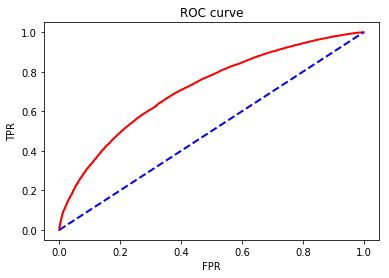

In [82]:
plot_roc(best_model, x_test, y_test)

In [84]:
feature_importances = best_model.get_feature_importance(train_pool)
feature_names = x_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

annual_inc: 10.28807747251628
int_rate: 10.199755722963788
sub_grade: 9.920663666600758
dti: 7.89870562758327
revol_util: 6.464957146617253
tot_cur_bal: 6.027221582883288
total_acc: 5.284012073547769
revol_bal: 5.25757333569273
loan_amnt: 4.9219575423384505
total_rev_hi_lim: 4.8454592013340685
open_acc: 4.593930245411311
installment: 4.51746594138508
verification_status: 4.399792004641423
term: 4.075371528961865
inq_last_6mths: 3.2162435991716105
home_ownership: 3.2147613531507595
tot_coll_amt: 1.7709914987648305
initial_list_status: 1.5953499878287118
purpose: 1.507710468606745


In [85]:
# make it True if your want to use GPU for training
have_gpu = False
# skip hyper-parameter optimization and just use provided optimal parameters
use_optimal_pretrained_params = False
# number of iterations of hyper-parameter search
hyperopt_iterations = 50

In [86]:
const_params = frozendict.frozendict({
    'task_type': 'GPU' if have_gpu else 'CPU',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC', 
    'od_type': 'Iter',
    'od_wait': 40,
    'custom_metric': ['AUC'],
    'iterations': 400,
    'random_seed':42})

In [99]:
class UciAdultClassifierObjective(object):
    def __init__(self, dataset, const_params, fold_count):
        self._dataset = dataset
        self._const_params = const_params.copy()
        self._fold_count = fold_count
        self._evaluated_count = 0
        
    def _to_catboost_params(self, hyper_params):
        return {
            'learning_rate': hyper_params['learning_rate'],
            'max_depth': hyper_params['max_depth'],
            'colsample_bylevel' : hyper_params['colsample_bylevel'],
            'bagging_temperature' : hyper_params['bagging_temperature'],
            'random_strength' : hyper_params['random_strength'],
            'scale_pos_weight' : hyper_params['scale_pos_weight']}
    def __call__(self, hyper_params):
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('evaluating params={}'.format(params), file=sys.stdout)
        sys.stdout.flush()        
        scores = cb.cv(
            pool=self._dataset,
            params=params,
            fold_count=self._fold_count,
            partition_random_seed=42,
            verbose=False)
        min_mean_auc = np.min(scores['test-AUC-mean'])
        print('evaluated score={}'.format(min_mean_auc), file=sys.stdout)
        
        self._evaluated_count += 1
        print('evaluated {} times'.format(self._evaluated_count), file=sys.stdout)
        
        # negate because hyperopt minimizes the objective
        return {'loss': -min_mean_auc, 'status': hyperopt.STATUS_OK}

In [100]:
def find_best_hyper_params(dataset, const_params, max_evals=100):    
    # we are going to optimize these three parameters, though there are a lot more of them (see CatBoost docs)
    parameter_space = {
                        'learning_rate': hyperopt.hp.uniform('learning_rate', 0.01, 0.8),
                        'max_depth':  hp.quniform("depth", 4, 10, 1),
                        'colsample_bylevel': hyperopt.hp.uniform('colsample_bylevel', 0.5, 1.0),
                        'bagging_temperature': hyperopt.hp.uniform('bagging_temperature', 0.0, 100),
                        'random_strength': hyperopt.hp.uniform('random_strength', 0.0, 100),
                        'scale_pos_weight': hyperopt.hp.uniform('scale_pos_weight', 1.0, 16.0)} # change 16.0 to n_negative / n_poistive}
 
    objective = UciAdultClassifierObjective(dataset=dataset, const_params=const_params, fold_count=6)
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
        fn=objective,
        space=parameter_space,
        algo=hyperopt.rand.suggest,
        max_evals=max_evals,
        rstate=np.random.RandomState(seed=42))
    return best

def train_best_model(dataset, const_params, max_evals=100, use_default=False):
    # convert pandas.DataFrame to catboost.Pool to avoid converting it on each 
    # iteration of hyper-parameters optimization  
    if use_default:
        # pretrained optimal parameters
        best = {
            'learning_rate': 0.4234185321620083, 
            'depth': 5, 
            'l2_leaf_reg': 9.464266235679002}
    else:
        best = find_best_hyper_params(dataset, const_params, max_evals=max_evals)
    
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = cb.CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params



In [101]:
model, params = train_best_model(
    train_pool, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)

evaluating params={'learning_rate': 0.06455055929014733, 'max_depth': 6.0, 'colsample_bylevel': 0.7425935964879817, 'bagging_temperature': 29.826163136513074, 'random_strength': 83.26320323149598, 'scale_pos_weight': 7.820515783320582, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6304917651443817                                                                                     
evaluated 1 times                                                                                                      
evaluating params={'learning_rate': 0.7469657190897886, 'max_depth': 6.0, 'colsample_bylevel': 0.8350739741344673, 'bagging_temperature': 41.411863248553836, 'random_strength': 72.77257431773249, 'scale_pos_weight': 7.151559382799706, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': 

evaluated score=0.5                                                                                                    
evaluated 13 times                                                                                                     
evaluating params={'learning_rate': 0.6816071034106231, 'max_depth': 6.0, 'colsample_bylevel': 0.8987194012367643, 'bagging_temperature': 17.39917225073908, 'random_strength': 1.3183035637853835, 'scale_pos_weight': 8.906647116199107, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.634674443641393                                                                                      
evaluated 14 times                                                                                                     
evaluating params={'learning_rate': 0.19800717762087047, 'max_depth': 7.0, 'colsample_bylevel': 0.6308684032130806, '

evaluating params={'learning_rate': 0.6990952871256788, 'max_depth': 7.0, 'colsample_bylevel': 0.9886431821208913, 'bagging_temperature': 37.02268496294152, 'random_strength': 30.46124241138234, 'scale_pos_weight': 5.956456248816514, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.5                                                                                                    
evaluated 26 times                                                                                                     
evaluating params={'learning_rate': 0.24329907330073666, 'max_depth': 8.0, 'colsample_bylevel': 0.7808420826245261, 'bagging_temperature': 20.368720717700416, 'random_strength': 70.4583602067651, 'scale_pos_weight': 13.45498682238244, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['

evaluated score=0.614419286417737                                                                                      
evaluated 38 times                                                                                                     
evaluating params={'learning_rate': 0.3176903626733709, 'max_depth': 5.0, 'colsample_bylevel': 0.7576107737512063, 'bagging_temperature': 69.77740837456095, 'random_strength': 3.7277118258843833, 'scale_pos_weight': 11.63786487812268, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.5                                                                                                    
evaluated 39 times                                                                                                     
evaluating params={'learning_rate': 0.5116330929422992, 'max_depth': 6.0, 'colsample_bylevel': 0.6881294671910385, 'b

In [261]:
params

{'depth': 7.0,
 'l2_leaf_reg': 4.2312063872926355,
 'learning_rate': 0.29621731293760284,
 'rsm': 0.904269839625579,
 'task_type': 'CPU',
 'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'od_type': 'Iter',
 'od_wait': 40,
 'custom_metric': ['AUC'],
 'iterations': 400,
 'random_seed': 42}

ROC-AUC score:  0.6600437673877269


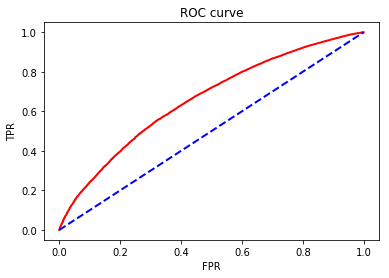

In [104]:
plot_roc(model, x_test, y_test)

In [105]:
show_scores(model, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


In [106]:
best_model_params = params.copy()
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

0:	test: 0.6506187	best: 0.6506187 (0)	total: 198ms	remaining: 1m 18s
1:	test: 0.6616630	best: 0.6616630 (1)	total: 386ms	remaining: 1m 16s
2:	test: 0.6870829	best: 0.6870829 (2)	total: 572ms	remaining: 1m 15s
3:	test: 0.6914128	best: 0.6914128 (3)	total: 780ms	remaining: 1m 17s
4:	test: 0.6922081	best: 0.6922081 (4)	total: 986ms	remaining: 1m 17s
5:	test: 0.6935561	best: 0.6935561 (5)	total: 1.16s	remaining: 1m 16s
6:	test: 0.6935872	best: 0.6935872 (6)	total: 1.34s	remaining: 1m 15s
7:	test: 0.6936241	best: 0.6936241 (7)	total: 1.53s	remaining: 1m 14s
8:	test: 0.6934693	best: 0.6936241 (7)	total: 1.72s	remaining: 1m 14s
9:	test: 0.6940850	best: 0.6940850 (9)	total: 1.92s	remaining: 1m 14s
10:	test: 0.6940632	best: 0.6940850 (9)	total: 2.1s	remaining: 1m 14s
11:	test: 0.6955371	best: 0.6955371 (11)	total: 2.29s	remaining: 1m 13s
12:	test: 0.6951506	best: 0.6955371 (11)	total: 2.5s	remaining: 1m 14s
13:	test: 0.6948797	best: 0.6955371 (11)	total: 2.7s	remaining: 1m 14s
14:	test: 0.6953

In [107]:
feature_importances = best_model.get_feature_importance(train_pool)
feature_names = x_train.columns
top = []
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    top.append(name)
    print('{}: {}'.format(name, score))

int_rate: 25.972716175084315
dti: 11.031957842542475
annual_inc: 8.472242449932239
sub_grade: 6.462579401078634
total_acc: 6.1212014051391215
installment: 6.034723638012342
revol_util: 6.0337568882955335
tot_cur_bal: 5.1400669982907035
term: 4.536905142706872
revol_bal: 3.4909984431866565
loan_amnt: 2.8725740327126212
open_acc: 2.726149596281768
total_rev_hi_lim: 2.702060545235106
initial_list_status: 2.304980919731754
tot_coll_amt: 1.9502617844433556
purpose: 1.8085408452516178
inq_last_6mths: 1.58969784576102
home_ownership: 0.7485860463138752
verification_status: 0.0


In [108]:
x = train.loc[:,['annual_inc','verification_status','int_rate','initial_list_status','term',
                 'installment','open_acc','total_acc','dti','purpose','tot_cur_bal',
                 'sub_grade','home_ownership','inq_last_6mths','total_rev_hi_lim',
                 'revol_bal','revol_util',
                 'tot_coll_amt','loan_amnt',] ] # параметры
x.drop(top[-1], axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [109]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [110]:
categorical_features_names = x.columns[x_train.dtypes == 'object']
categorical_features_names

Index(['verification_status', 'initial_list_status', 'purpose',
       'home_ownership'],
      dtype='object')

In [111]:
categorical_features_indices = [x.columns.get_loc(i) for i in categorical_features_names]

In [112]:
if 'purpose' in categorical_features_names:
    x['purpose'] = x['purpose'].astype(str).map(lambda x: 'other' if x in ['educational', 'renewable_energy','vacation','house','wedding','moving','medical','car','small_business','major_purchase'] else x)

In [113]:
if 'term' in categorical_features_names:
    x['term'] = x['term'].astype(str).map(lambda x: 36 if x == ' 36 months' else 60)

In [114]:
if 'sub_grade' in categorical_features_names:
    x['sub_grade'] = x['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))


In [115]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

In [116]:
categorical_features_names = x_train.columns[x_train.dtypes == 'object']
categorical_features_names

Index(['verification_status', 'initial_list_status', 'term', 'purpose',
       'sub_grade', 'home_ownership'],
      dtype='object')

In [117]:
categorical_features_indices = [x_train.columns.get_loc(i) for i in categorical_features_names]
categorical_features_indices

[1, 3, 4, 9, 11, 12]

In [118]:
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(x_test, y_test, cat_features=categorical_features_indices)

In [119]:
model, params = train_best_model(
    train_pool, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)

evaluating params={'learning_rate': 0.06455055929014733, 'max_depth': 6.0, 'colsample_bylevel': 0.7425935964879817, 'bagging_temperature': 29.826163136513074, 'random_strength': 83.26320323149598, 'scale_pos_weight': 7.820515783320582, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6170791541759072                                                                                     
evaluated 1 times                                                                                                      
evaluating params={'learning_rate': 0.7469657190897886, 'max_depth': 6.0, 'colsample_bylevel': 0.8350739741344673, 'bagging_temperature': 41.411863248553836, 'random_strength': 72.77257431773249, 'scale_pos_weight': 7.151559382799706, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': 

evaluated score=0.5                                                                                                    
evaluated 13 times                                                                                                     
evaluating params={'learning_rate': 0.6816071034106231, 'max_depth': 6.0, 'colsample_bylevel': 0.8987194012367643, 'bagging_temperature': 17.39917225073908, 'random_strength': 1.3183035637853835, 'scale_pos_weight': 8.906647116199107, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6195643399797982                                                                                     
evaluated 14 times                                                                                                     
evaluating params={'learning_rate': 0.19800717762087047, 'max_depth': 7.0, 'colsample_bylevel': 0.6308684032130806, '

evaluating params={'learning_rate': 0.6990952871256788, 'max_depth': 7.0, 'colsample_bylevel': 0.9886431821208913, 'bagging_temperature': 37.02268496294152, 'random_strength': 30.46124241138234, 'scale_pos_weight': 5.956456248816514, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.5                                                                                                    
evaluated 26 times                                                                                                     
evaluating params={'learning_rate': 0.24329907330073666, 'max_depth': 8.0, 'colsample_bylevel': 0.7808420826245261, 'bagging_temperature': 20.368720717700416, 'random_strength': 70.4583602067651, 'scale_pos_weight': 13.45498682238244, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['

evaluated score=0.6242661950947407                                                                                     
evaluated 38 times                                                                                                     
evaluating params={'learning_rate': 0.3176903626733709, 'max_depth': 5.0, 'colsample_bylevel': 0.7576107737512063, 'bagging_temperature': 69.77740837456095, 'random_strength': 3.7277118258843833, 'scale_pos_weight': 11.63786487812268, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.5                                                                                                    
evaluated 39 times                                                                                                     
evaluating params={'learning_rate': 0.5116330929422992, 'max_depth': 6.0, 'colsample_bylevel': 0.6881294671910385, 'b

In [120]:
params

{'bagging_temperature': 34.823504904022414,
 'colsample_bylevel': 0.5886668909032519,
 'depth': 10.0,
 'learning_rate': 0.20930792475812623,
 'random_strength': 78.52734938376074,
 'scale_pos_weight': 10.205598741673892,
 'task_type': 'CPU',
 'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'od_type': 'Iter',
 'od_wait': 40,
 'custom_metric': ['AUC'],
 'iterations': 400,
 'random_seed': 42}

ROC-AUC score:  0.7011905304629541


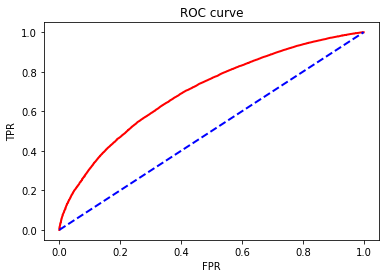

In [121]:
plot_roc(model, x_test, y_test)

In [122]:
show_scores(model, x_test, y_test)

Recall: 1.00
Precision score: 0.78
Accuracy score: 0.78


In [123]:
best_model_params = params.copy()
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

0:	test: 0.5000000	best: 0.5000000 (0)	total: 66.1ms	remaining: 26.4s
1:	test: 0.6471153	best: 0.6471153 (1)	total: 320ms	remaining: 1m 3s
2:	test: 0.6794989	best: 0.6794989 (2)	total: 567ms	remaining: 1m 15s
3:	test: 0.6881944	best: 0.6881944 (3)	total: 834ms	remaining: 1m 22s
4:	test: 0.6922573	best: 0.6922573 (4)	total: 1.08s	remaining: 1m 25s
5:	test: 0.6922573	best: 0.6922573 (4)	total: 1.15s	remaining: 1m 15s
6:	test: 0.6934423	best: 0.6934423 (6)	total: 1.4s	remaining: 1m 18s
7:	test: 0.6934423	best: 0.6934423 (6)	total: 1.46s	remaining: 1m 11s
8:	test: 0.6934423	best: 0.6934423 (6)	total: 1.52s	remaining: 1m 6s
9:	test: 0.6952976	best: 0.6952976 (9)	total: 1.78s	remaining: 1m 9s
10:	test: 0.6952976	best: 0.6952976 (9)	total: 1.84s	remaining: 1m 5s
11:	test: 0.6952976	best: 0.6952976 (9)	total: 1.91s	remaining: 1m 1s
12:	test: 0.6952976	best: 0.6952976 (9)	total: 1.98s	remaining: 58.8s
13:	test: 0.6952976	best: 0.6952976 (9)	total: 2.04s	remaining: 56.2s
14:	test: 0.6952976	best

116:	test: 0.7044309	best: 0.7044787 (100)	total: 17s	remaining: 41.1s
117:	test: 0.7044309	best: 0.7044787 (100)	total: 17s	remaining: 40.7s
118:	test: 0.7044309	best: 0.7044787 (100)	total: 17.1s	remaining: 40.4s
119:	test: 0.7044309	best: 0.7044787 (100)	total: 17.2s	remaining: 40s
120:	test: 0.7044309	best: 0.7044787 (100)	total: 17.2s	remaining: 39.7s
121:	test: 0.7044309	best: 0.7044787 (100)	total: 17.3s	remaining: 39.4s
122:	test: 0.7044309	best: 0.7044787 (100)	total: 17.3s	remaining: 39s
123:	test: 0.7045848	best: 0.7045848 (123)	total: 17.6s	remaining: 39.1s
124:	test: 0.7045728	best: 0.7045848 (123)	total: 17.8s	remaining: 39.2s
125:	test: 0.7045728	best: 0.7045848 (123)	total: 17.9s	remaining: 38.9s
126:	test: 0.7045728	best: 0.7045848 (123)	total: 17.9s	remaining: 38.6s
127:	test: 0.7045592	best: 0.7045848 (123)	total: 18.2s	remaining: 38.7s
128:	test: 0.7046933	best: 0.7046933 (128)	total: 18.4s	remaining: 38.7s
129:	test: 0.7046933	best: 0.7046933 (128)	total: 18.5s	rem

In [124]:
feature_importances = best_model.get_feature_importance(train_pool)
feature_names = x_train.columns
top = []
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    top.append(name)
    print('{}: {}'.format(name, score))

int_rate: 21.504196038063213
dti: 10.605154625081251
annual_inc: 10.371280993921673
term: 6.695732825877977
revol_util: 6.676160400542775
total_rev_hi_lim: 6.387607419290431
installment: 6.0609233086618195
revol_bal: 6.029617865607967
total_acc: 5.675356437658795
tot_cur_bal: 5.546080977803312
open_acc: 4.277378818312348
inq_last_6mths: 4.15021065474063
loan_amnt: 2.923083640417321
initial_list_status: 1.853440974575323
tot_coll_amt: 1.243775019445164
verification_status: 0.0
sub_grade: 0.0
purpose: 0.0
home_ownership: 0.0


In [125]:
x = train.loc[:,['annual_inc','verification_status','int_rate','initial_list_status','term',
                 'installment','open_acc','total_acc','dti','purpose','tot_cur_bal',
                 'sub_grade','home_ownership','inq_last_6mths','total_rev_hi_lim',
                 'revol_bal','revol_util',
                 'tot_coll_amt','loan_amnt',] ] # параметры
x.drop(top[-1], axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [126]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [127]:
categorical_features_names = x.columns[x_train.dtypes == 'object']
categorical_features_names

Index(['verification_status', 'initial_list_status', 'term', 'purpose',
       'sub_grade', 'home_ownership'],
      dtype='object')

In [128]:
categorical_features_indices = [x.columns.get_loc(i) for i in categorical_features_names]

In [129]:
if 'purpose' in categorical_features_names:
    x['purpose'] = x['purpose'].astype(str).map(lambda x: 'other' if x in ['educational', 'renewable_energy','vacation','house','wedding','moving','medical','car','small_business','major_purchase'] else x)

In [130]:
if 'term' in categorical_features_names:
    x['term'] = x['term'].astype(str).map(lambda x: 36 if x == ' 36 months' else 60)

In [131]:
if 'sub_grade' in categorical_features_names:
    x['sub_grade'] = x['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))

In [132]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

In [133]:
categorical_features_names = x_train.columns[x_train.dtypes == 'object']
categorical_features_names

Index(['verification_status', 'initial_list_status', 'purpose',
       'home_ownership'],
      dtype='object')

In [134]:
categorical_features_indices = [x_train.columns.get_loc(i) for i in categorical_features_names]
categorical_features_indices

[1, 3, 9, 12]

In [135]:
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(x_test, y_test, cat_features=categorical_features_indices)

In [136]:
model, params = train_best_model(
    train_pool, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)

evaluating params={'learning_rate': 0.06455055929014733, 'max_depth': 6.0, 'colsample_bylevel': 0.7425935964879817, 'bagging_temperature': 29.826163136513074, 'random_strength': 83.26320323149598, 'scale_pos_weight': 7.820515783320582, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6276106715588896                                                                                     
evaluated 1 times                                                                                                      
evaluating params={'learning_rate': 0.7469657190897886, 'max_depth': 6.0, 'colsample_bylevel': 0.8350739741344673, 'bagging_temperature': 41.411863248553836, 'random_strength': 72.77257431773249, 'scale_pos_weight': 7.151559382799706, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': 

evaluated score=0.5                                                                                                    
evaluated 13 times                                                                                                     
evaluating params={'learning_rate': 0.6816071034106231, 'max_depth': 6.0, 'colsample_bylevel': 0.8987194012367643, 'bagging_temperature': 17.39917225073908, 'random_strength': 1.3183035637853835, 'scale_pos_weight': 8.906647116199107, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6276201810816152                                                                                     
evaluated 14 times                                                                                                     
evaluating params={'learning_rate': 0.19800717762087047, 'max_depth': 7.0, 'colsample_bylevel': 0.6308684032130806, '

evaluating params={'learning_rate': 0.6990952871256788, 'max_depth': 7.0, 'colsample_bylevel': 0.9886431821208913, 'bagging_temperature': 37.02268496294152, 'random_strength': 30.46124241138234, 'scale_pos_weight': 5.956456248816514, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.5                                                                                                    
evaluated 26 times                                                                                                     
evaluating params={'learning_rate': 0.24329907330073666, 'max_depth': 8.0, 'colsample_bylevel': 0.7808420826245261, 'bagging_temperature': 20.368720717700416, 'random_strength': 70.4583602067651, 'scale_pos_weight': 13.45498682238244, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['

evaluated score=0.6348619929164084                                                                                     
evaluated 38 times                                                                                                     
evaluating params={'learning_rate': 0.3176903626733709, 'max_depth': 5.0, 'colsample_bylevel': 0.7576107737512063, 'bagging_temperature': 69.77740837456095, 'random_strength': 3.7277118258843833, 'scale_pos_weight': 11.63786487812268, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.5                                                                                                    
evaluated 39 times                                                                                                     
evaluating params={'learning_rate': 0.5116330929422992, 'max_depth': 6.0, 'colsample_bylevel': 0.6881294671910385, 'b

In [137]:
params

{'bagging_temperature': 12.738262171620264,
 'colsample_bylevel': 0.6655150483186099,
 'depth': 9.0,
 'learning_rate': 0.7044181740437416,
 'random_strength': 63.4490889188811,
 'scale_pos_weight': 6.314410522320887,
 'task_type': 'CPU',
 'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'od_type': 'Iter',
 'od_wait': 40,
 'custom_metric': ['AUC'],
 'iterations': 400,
 'random_seed': 42}

ROC-AUC score:  0.6633088870137023


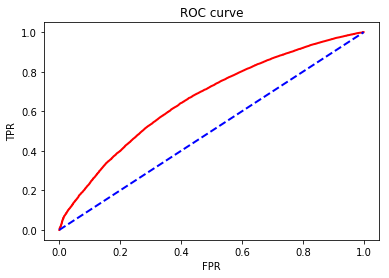

In [138]:
plot_roc(model, x_test, y_test)

In [139]:
show_scores(model, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


In [140]:
best_model_params = params.copy()
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

0:	test: 0.6580940	best: 0.6580940 (0)	total: 205ms	remaining: 1m 21s
1:	test: 0.6777828	best: 0.6777828 (1)	total: 405ms	remaining: 1m 20s
2:	test: 0.6839271	best: 0.6839271 (2)	total: 605ms	remaining: 1m 20s
3:	test: 0.6892552	best: 0.6892552 (3)	total: 804ms	remaining: 1m 19s
4:	test: 0.6899382	best: 0.6899382 (4)	total: 998ms	remaining: 1m 18s
5:	test: 0.6915935	best: 0.6915935 (5)	total: 1.21s	remaining: 1m 19s
6:	test: 0.6966695	best: 0.6966695 (6)	total: 1.42s	remaining: 1m 19s
7:	test: 0.6977415	best: 0.6977415 (7)	total: 1.62s	remaining: 1m 19s
8:	test: 0.6983433	best: 0.6983433 (8)	total: 1.82s	remaining: 1m 19s
9:	test: 0.6979878	best: 0.6983433 (8)	total: 2.03s	remaining: 1m 19s
10:	test: 0.6975638	best: 0.6983433 (8)	total: 2.23s	remaining: 1m 18s
11:	test: 0.6975558	best: 0.6983433 (8)	total: 2.43s	remaining: 1m 18s
12:	test: 0.6976357	best: 0.6983433 (8)	total: 2.62s	remaining: 1m 18s
13:	test: 0.6971368	best: 0.6983433 (8)	total: 2.8s	remaining: 1m 17s
14:	test: 0.69796

In [141]:
feature_importances = best_model.get_feature_importance(train_pool)
feature_names = x_train.columns
top = []
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    top.append(name)
    print('{}: {}'.format(name, score))

int_rate: 15.860616178747385
sub_grade: 11.780854949889742
annual_inc: 10.863742768717033
dti: 9.34078683317974
total_acc: 7.093918317260992
revol_util: 6.865832918066042
total_rev_hi_lim: 6.487557443154288
loan_amnt: 5.653919377029446
tot_cur_bal: 5.478489916316179
revol_bal: 5.033608175850027
installment: 4.119185936090789
term: 3.6262332467325256
open_acc: 3.1607786593777285
inq_last_6mths: 2.6268205387308163
initial_list_status: 1.4808889504151654
tot_coll_amt: 0.5267657904420879
verification_status: 0.0
purpose: 0.0
home_ownership: 0.0


In [142]:
x = train.loc[:,['annual_inc','verification_status','int_rate','initial_list_status','term',
                 'installment','open_acc','total_acc','dti','purpose','tot_cur_bal',
                 'sub_grade','home_ownership','inq_last_6mths','total_rev_hi_lim',
                 'revol_bal','revol_util',
                 'tot_coll_amt','loan_amnt',] ] # параметры
x.drop(top[-1], axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [143]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [144]:
categorical_features_names = x.columns[x_train.dtypes == 'object']
categorical_features_names

Index(['verification_status', 'initial_list_status', 'purpose',
       'home_ownership'],
      dtype='object')

In [145]:
categorical_features_indices = [x.columns.get_loc(i) for i in categorical_features_names]

In [146]:
if 'purpose' in categorical_features_names:
    x['purpose'] = x['purpose'].astype(str).map(lambda x: 'other' if x in ['educational', 'renewable_energy','vacation','house','wedding','moving','medical','car','small_business','major_purchase'] else x)

In [147]:
if 'term' in categorical_features_names:
    x['term'] = x['term'].astype(str).map(lambda x: 36 if x == ' 36 months' else 60)

In [148]:
if 'sub_grade' in categorical_features_names:
    x['sub_grade'] = x['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))

In [149]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

In [150]:
categorical_features_names = x_train.columns[x_train.dtypes == 'object']
categorical_features_names

Index(['verification_status', 'initial_list_status', 'term', 'purpose',
       'sub_grade', 'home_ownership'],
      dtype='object')

In [151]:
categorical_features_indices = [x_train.columns.get_loc(i) for i in categorical_features_names]
categorical_features_indices

[1, 3, 4, 9, 11, 12]

In [152]:
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(x_test, y_test, cat_features=categorical_features_indices)

In [153]:
model, params = train_best_model(
    train_pool, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)

evaluating params={'learning_rate': 0.06455055929014733, 'max_depth': 6.0, 'colsample_bylevel': 0.7425935964879817, 'bagging_temperature': 29.826163136513074, 'random_strength': 83.26320323149598, 'scale_pos_weight': 7.820515783320582, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6170791541759072                                                                                     
evaluated 1 times                                                                                                      
evaluating params={'learning_rate': 0.7469657190897886, 'max_depth': 6.0, 'colsample_bylevel': 0.8350739741344673, 'bagging_temperature': 41.411863248553836, 'random_strength': 72.77257431773249, 'scale_pos_weight': 7.151559382799706, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': 

evaluated score=0.5                                                                                                    
evaluated 13 times                                                                                                     
evaluating params={'learning_rate': 0.6816071034106231, 'max_depth': 6.0, 'colsample_bylevel': 0.8987194012367643, 'bagging_temperature': 17.39917225073908, 'random_strength': 1.3183035637853835, 'scale_pos_weight': 8.906647116199107, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6195643399797982                                                                                     
evaluated 14 times                                                                                                     
evaluating params={'learning_rate': 0.19800717762087047, 'max_depth': 7.0, 'colsample_bylevel': 0.6308684032130806, '

evaluating params={'learning_rate': 0.6990952871256788, 'max_depth': 7.0, 'colsample_bylevel': 0.9886431821208913, 'bagging_temperature': 37.02268496294152, 'random_strength': 30.46124241138234, 'scale_pos_weight': 5.956456248816514, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.5                                                                                                    
evaluated 26 times                                                                                                     
evaluating params={'learning_rate': 0.24329907330073666, 'max_depth': 8.0, 'colsample_bylevel': 0.7808420826245261, 'bagging_temperature': 20.368720717700416, 'random_strength': 70.4583602067651, 'scale_pos_weight': 13.45498682238244, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['

evaluated score=0.6242661950947407                                                                                     
evaluated 38 times                                                                                                     
evaluating params={'learning_rate': 0.3176903626733709, 'max_depth': 5.0, 'colsample_bylevel': 0.7576107737512063, 'bagging_temperature': 69.77740837456095, 'random_strength': 3.7277118258843833, 'scale_pos_weight': 11.63786487812268, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.5                                                                                                    
evaluated 39 times                                                                                                     
evaluating params={'learning_rate': 0.5116330929422992, 'max_depth': 6.0, 'colsample_bylevel': 0.6881294671910385, 'b

In [154]:
params

{'bagging_temperature': 34.823504904022414,
 'colsample_bylevel': 0.5886668909032519,
 'depth': 10.0,
 'learning_rate': 0.20930792475812623,
 'random_strength': 78.52734938376074,
 'scale_pos_weight': 10.205598741673892,
 'task_type': 'CPU',
 'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'od_type': 'Iter',
 'od_wait': 40,
 'custom_metric': ['AUC'],
 'iterations': 400,
 'random_seed': 42}

ROC-AUC score:  0.7011905304629541


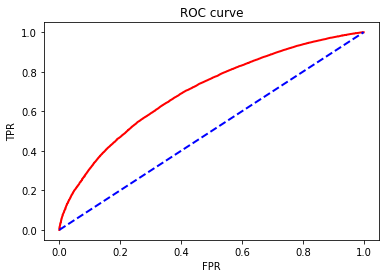

In [155]:
plot_roc(model, x_test, y_test)

In [156]:
show_scores(model, x_test, y_test)

Recall: 1.00
Precision score: 0.78
Accuracy score: 0.78


In [157]:
best_model_params = params.copy()
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

0:	test: 0.5000000	best: 0.5000000 (0)	total: 68ms	remaining: 27.1s
1:	test: 0.6471153	best: 0.6471153 (1)	total: 327ms	remaining: 1m 5s
2:	test: 0.6794989	best: 0.6794989 (2)	total: 570ms	remaining: 1m 15s
3:	test: 0.6881944	best: 0.6881944 (3)	total: 830ms	remaining: 1m 22s
4:	test: 0.6922573	best: 0.6922573 (4)	total: 1.08s	remaining: 1m 25s
5:	test: 0.6922573	best: 0.6922573 (4)	total: 1.14s	remaining: 1m 15s
6:	test: 0.6934423	best: 0.6934423 (6)	total: 1.39s	remaining: 1m 18s
7:	test: 0.6934423	best: 0.6934423 (6)	total: 1.45s	remaining: 1m 11s
8:	test: 0.6934423	best: 0.6934423 (6)	total: 1.51s	remaining: 1m 5s
9:	test: 0.6952976	best: 0.6952976 (9)	total: 1.77s	remaining: 1m 8s
10:	test: 0.6952976	best: 0.6952976 (9)	total: 1.83s	remaining: 1m 4s
11:	test: 0.6952976	best: 0.6952976 (9)	total: 1.9s	remaining: 1m 1s
12:	test: 0.6952976	best: 0.6952976 (9)	total: 1.96s	remaining: 58.4s
13:	test: 0.6952976	best: 0.6952976 (9)	total: 2.02s	remaining: 55.7s
14:	test: 0.6952976	best: 

116:	test: 0.7044309	best: 0.7044787 (100)	total: 16.9s	remaining: 41s
117:	test: 0.7044309	best: 0.7044787 (100)	total: 17s	remaining: 40.6s
118:	test: 0.7044309	best: 0.7044787 (100)	total: 17.1s	remaining: 40.3s
119:	test: 0.7044309	best: 0.7044787 (100)	total: 17.1s	remaining: 40s
120:	test: 0.7044309	best: 0.7044787 (100)	total: 17.2s	remaining: 39.6s
121:	test: 0.7044309	best: 0.7044787 (100)	total: 17.2s	remaining: 39.3s
122:	test: 0.7044309	best: 0.7044787 (100)	total: 17.3s	remaining: 38.9s
123:	test: 0.7045848	best: 0.7045848 (123)	total: 17.5s	remaining: 39s
124:	test: 0.7045728	best: 0.7045848 (123)	total: 17.8s	remaining: 39.1s
125:	test: 0.7045728	best: 0.7045848 (123)	total: 17.8s	remaining: 38.8s
126:	test: 0.7045728	best: 0.7045848 (123)	total: 17.9s	remaining: 38.5s
127:	test: 0.7045592	best: 0.7045848 (123)	total: 18.2s	remaining: 38.6s
128:	test: 0.7046933	best: 0.7046933 (128)	total: 18.4s	remaining: 38.6s
129:	test: 0.7046933	best: 0.7046933 (128)	total: 18.5s	rem

In [158]:
feature_importances = best_model.get_feature_importance(train_pool)
feature_names = x_train.columns
top = []
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    top.append(name)
    print('{}: {}'.format(name, score))

int_rate: 21.504196038063213
dti: 10.605154625081251
annual_inc: 10.371280993921673
term: 6.695732825877977
revol_util: 6.676160400542775
total_rev_hi_lim: 6.387607419290431
installment: 6.0609233086618195
revol_bal: 6.029617865607967
total_acc: 5.675356437658795
tot_cur_bal: 5.546080977803312
open_acc: 4.277378818312348
inq_last_6mths: 4.15021065474063
loan_amnt: 2.923083640417321
initial_list_status: 1.853440974575323
tot_coll_amt: 1.243775019445164
verification_status: 0.0
sub_grade: 0.0
purpose: 0.0
home_ownership: 0.0


In [159]:
x = train.loc[:,['annual_inc','verification_status','int_rate','initial_list_status','term',
                 'installment','open_acc','total_acc','dti','purpose','tot_cur_bal',
                 'sub_grade','home_ownership','inq_last_6mths','total_rev_hi_lim',
                 'revol_bal','revol_util',
                 'tot_coll_amt','loan_amnt',] ] # параметры
x.drop(top[-1], axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [160]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [161]:
categorical_features_names = x.columns[x_train.dtypes == 'object']
categorical_features_names

Index(['verification_status', 'initial_list_status', 'term', 'purpose',
       'sub_grade', 'home_ownership'],
      dtype='object')

In [162]:
categorical_features_indices = [x.columns.get_loc(i) for i in categorical_features_names]

In [163]:
if 'purpose' in categorical_features_names:
    x['purpose'] = x['purpose'].astype(str).map(lambda x: 'other' if x in ['educational', 'renewable_energy','vacation','house','wedding','moving','medical','car','small_business','major_purchase'] else x)

In [164]:
if 'term' in categorical_features_names:
    x['term'] = x['term'].astype(str).map(lambda x: 36 if x == ' 36 months' else 60)

In [165]:
if 'sub_grade' in categorical_features_names:
    x['sub_grade'] = x['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))

In [166]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

In [167]:
categorical_features_names = x_train.columns[x_train.dtypes == 'object']
categorical_features_names

Index(['verification_status', 'initial_list_status', 'purpose',
       'home_ownership'],
      dtype='object')

In [168]:
categorical_features_indices = [x_train.columns.get_loc(i) for i in categorical_features_names]
categorical_features_indices

[1, 3, 9, 12]

In [169]:
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(x_test, y_test, cat_features=categorical_features_indices)

In [170]:
model, params = train_best_model(
    train_pool, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)

evaluating params={'learning_rate': 0.06455055929014733, 'max_depth': 6.0, 'colsample_bylevel': 0.7425935964879817, 'bagging_temperature': 29.826163136513074, 'random_strength': 83.26320323149598, 'scale_pos_weight': 7.820515783320582, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6276106715588896                                                                                     
evaluated 1 times                                                                                                      
evaluating params={'learning_rate': 0.7469657190897886, 'max_depth': 6.0, 'colsample_bylevel': 0.8350739741344673, 'bagging_temperature': 41.411863248553836, 'random_strength': 72.77257431773249, 'scale_pos_weight': 7.151559382799706, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': 

evaluated score=0.5                                                                                                    
evaluated 13 times                                                                                                     
evaluating params={'learning_rate': 0.6816071034106231, 'max_depth': 6.0, 'colsample_bylevel': 0.8987194012367643, 'bagging_temperature': 17.39917225073908, 'random_strength': 1.3183035637853835, 'scale_pos_weight': 8.906647116199107, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6276201810816152                                                                                     
evaluated 14 times                                                                                                     
evaluating params={'learning_rate': 0.19800717762087047, 'max_depth': 7.0, 'colsample_bylevel': 0.6308684032130806, '

evaluating params={'learning_rate': 0.6990952871256788, 'max_depth': 7.0, 'colsample_bylevel': 0.9886431821208913, 'bagging_temperature': 37.02268496294152, 'random_strength': 30.46124241138234, 'scale_pos_weight': 5.956456248816514, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.5                                                                                                    
evaluated 26 times                                                                                                     
evaluating params={'learning_rate': 0.24329907330073666, 'max_depth': 8.0, 'colsample_bylevel': 0.7808420826245261, 'bagging_temperature': 20.368720717700416, 'random_strength': 70.4583602067651, 'scale_pos_weight': 13.45498682238244, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['

evaluated score=0.6348619929164084                                                                                     
evaluated 38 times                                                                                                     
evaluating params={'learning_rate': 0.3176903626733709, 'max_depth': 5.0, 'colsample_bylevel': 0.7576107737512063, 'bagging_temperature': 69.77740837456095, 'random_strength': 3.7277118258843833, 'scale_pos_weight': 11.63786487812268, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.5                                                                                                    
evaluated 39 times                                                                                                     
evaluating params={'learning_rate': 0.5116330929422992, 'max_depth': 6.0, 'colsample_bylevel': 0.6881294671910385, 'b

In [171]:
params

{'bagging_temperature': 12.738262171620264,
 'colsample_bylevel': 0.6655150483186099,
 'depth': 9.0,
 'learning_rate': 0.7044181740437416,
 'random_strength': 63.4490889188811,
 'scale_pos_weight': 6.314410522320887,
 'task_type': 'CPU',
 'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'od_type': 'Iter',
 'od_wait': 40,
 'custom_metric': ['AUC'],
 'iterations': 400,
 'random_seed': 42}

ROC-AUC score:  0.6633088870137023


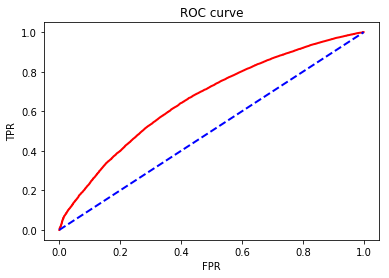

In [172]:
plot_roc(model, x_test, y_test)

In [173]:
show_scores(model, x_test, y_test)

Recall: 0.98
Precision score: 0.79
Accuracy score: 0.78


In [174]:
best_model_params = params.copy()
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

0:	test: 0.6580940	best: 0.6580940 (0)	total: 203ms	remaining: 1m 21s
1:	test: 0.6777828	best: 0.6777828 (1)	total: 405ms	remaining: 1m 20s
2:	test: 0.6839271	best: 0.6839271 (2)	total: 608ms	remaining: 1m 20s
3:	test: 0.6892552	best: 0.6892552 (3)	total: 820ms	remaining: 1m 21s
4:	test: 0.6899382	best: 0.6899382 (4)	total: 1.01s	remaining: 1m 19s
5:	test: 0.6915935	best: 0.6915935 (5)	total: 1.23s	remaining: 1m 20s
6:	test: 0.6966695	best: 0.6966695 (6)	total: 1.43s	remaining: 1m 20s
7:	test: 0.6977415	best: 0.6977415 (7)	total: 1.63s	remaining: 1m 19s
8:	test: 0.6983433	best: 0.6983433 (8)	total: 1.82s	remaining: 1m 19s
9:	test: 0.6979878	best: 0.6983433 (8)	total: 2.04s	remaining: 1m 19s
10:	test: 0.6975638	best: 0.6983433 (8)	total: 2.24s	remaining: 1m 19s
11:	test: 0.6975558	best: 0.6983433 (8)	total: 2.45s	remaining: 1m 19s
12:	test: 0.6976357	best: 0.6983433 (8)	total: 2.65s	remaining: 1m 18s
13:	test: 0.6971368	best: 0.6983433 (8)	total: 2.84s	remaining: 1m 18s
14:	test: 0.6979

In [175]:
feature_importances = best_model.get_feature_importance(train_pool)
feature_names = x_train.columns
top = []
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    top.append(name)
    print('{}: {}'.format(name, score))

int_rate: 15.860616178747385
sub_grade: 11.780854949889742
annual_inc: 10.863742768717033
dti: 9.34078683317974
total_acc: 7.093918317260992
revol_util: 6.865832918066042
total_rev_hi_lim: 6.487557443154288
loan_amnt: 5.653919377029446
tot_cur_bal: 5.478489916316179
revol_bal: 5.033608175850027
installment: 4.119185936090789
term: 3.6262332467325256
open_acc: 3.1607786593777285
inq_last_6mths: 2.6268205387308163
initial_list_status: 1.4808889504151654
tot_coll_amt: 0.5267657904420879
verification_status: 0.0
purpose: 0.0
home_ownership: 0.0


In [176]:
x = train.loc[:,['annual_inc','verification_status','int_rate','initial_list_status','term',
                 'installment','open_acc','total_acc','dti','purpose','tot_cur_bal',
                 'sub_grade','home_ownership','inq_last_6mths','total_rev_hi_lim',
                 'revol_bal','revol_util',
                 'tot_coll_amt','loan_amnt',] ] # параметры
x.drop(top[-1], axis=1)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [177]:
#NaN killer
Nan_killer(x)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200189 entries, 0 to 200188
Data columns (total 19 columns):
annual_inc             200189 non-null float64
verification_status    200189 non-null object
int_rate               200189 non-null float64
initial_list_status    200189 non-null object
term                   200189 non-null object
installment            200189 non-null float64
open_acc               200189 non-null float64
total_acc              200189 non-null float64
dti                    200189 non-null float64
purpose                200189 non-null object
tot_cur_bal            152232 non-null float64
sub_grade              200189 non-null object
home_ownership         200189 non-null object
inq_last_6mths         200189 non-null float64
total_rev_hi_lim       152232 non-null float64
revol_bal              200189 non-null float64
revol_util             200035 non-null float64
tot_coll_amt           152232 non-null float64
loan_amnt              200189 non-null float64
dt

In [178]:
categorical_features_names = x.columns[x_train.dtypes == 'object']
categorical_features_names

Index(['verification_status', 'initial_list_status', 'purpose',
       'home_ownership'],
      dtype='object')

In [179]:
categorical_features_indices = [x.columns.get_loc(i) for i in categorical_features_names]

In [180]:
if 'purpose' in categorical_features_names:
    x['purpose'] = x['purpose'].astype(str).map(lambda x: 'other' if x in ['educational', 'renewable_energy','vacation','house','wedding','moving','medical','car','small_business','major_purchase'] else x)

In [181]:
if 'term' in categorical_features_names:
    x['term'] = x['term'].astype(str).map(lambda x: 36 if x == ' 36 months' else 60)

In [182]:
if 'sub_grade' in categorical_features_names:
    x['sub_grade'] = x['sub_grade'].astype('str').map(lambda x: ord(x[0])*10 + int(x[1]))

In [183]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)

In [184]:
categorical_features_names = x_train.columns[x_train.dtypes == 'object']
categorical_features_names

Index(['verification_status', 'initial_list_status', 'term', 'purpose',
       'sub_grade', 'home_ownership'],
      dtype='object')

In [185]:
categorical_features_indices = [x_train.columns.get_loc(i) for i in categorical_features_names]
categorical_features_indices

[1, 3, 4, 9, 11, 12]

In [186]:
train_pool = Pool(x_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(x_test, y_test, cat_features=categorical_features_indices)

In [187]:
model, params = train_best_model(
    train_pool, 
    const_params, 
    max_evals=hyperopt_iterations, 
    use_default=use_optimal_pretrained_params)

evaluating params={'learning_rate': 0.06455055929014733, 'max_depth': 6.0, 'colsample_bylevel': 0.7425935964879817, 'bagging_temperature': 29.826163136513074, 'random_strength': 83.26320323149598, 'scale_pos_weight': 7.820515783320582, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6170791541759072                                                                                     
evaluated 1 times                                                                                                      
evaluating params={'learning_rate': 0.7469657190897886, 'max_depth': 6.0, 'colsample_bylevel': 0.8350739741344673, 'bagging_temperature': 41.411863248553836, 'random_strength': 72.77257431773249, 'scale_pos_weight': 7.151559382799706, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': 

evaluated score=0.5                                                                                                    
evaluated 13 times                                                                                                     
evaluating params={'learning_rate': 0.6816071034106231, 'max_depth': 6.0, 'colsample_bylevel': 0.8987194012367643, 'bagging_temperature': 17.39917225073908, 'random_strength': 1.3183035637853835, 'scale_pos_weight': 8.906647116199107, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.6195643399797982                                                                                     
evaluated 14 times                                                                                                     
evaluating params={'learning_rate': 0.19800717762087047, 'max_depth': 7.0, 'colsample_bylevel': 0.6308684032130806, '

evaluating params={'learning_rate': 0.6990952871256788, 'max_depth': 7.0, 'colsample_bylevel': 0.9886431821208913, 'bagging_temperature': 37.02268496294152, 'random_strength': 30.46124241138234, 'scale_pos_weight': 5.956456248816514, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.5                                                                                                    
evaluated 26 times                                                                                                     
evaluating params={'learning_rate': 0.24329907330073666, 'max_depth': 8.0, 'colsample_bylevel': 0.7808420826245261, 'bagging_temperature': 20.368720717700416, 'random_strength': 70.4583602067651, 'scale_pos_weight': 13.45498682238244, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['

evaluated score=0.6242661950947407                                                                                     
evaluated 38 times                                                                                                     
evaluating params={'learning_rate': 0.3176903626733709, 'max_depth': 5.0, 'colsample_bylevel': 0.7576107737512063, 'bagging_temperature': 69.77740837456095, 'random_strength': 3.7277118258843833, 'scale_pos_weight': 11.63786487812268, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'AUC', 'od_type': 'Iter', 'od_wait': 40, 'custom_metric': ['AUC'], 'iterations': 400, 'random_seed': 42}
evaluated score=0.5                                                                                                    
evaluated 39 times                                                                                                     
evaluating params={'learning_rate': 0.5116330929422992, 'max_depth': 6.0, 'colsample_bylevel': 0.6881294671910385, 'b

In [188]:
params

{'bagging_temperature': 34.823504904022414,
 'colsample_bylevel': 0.5886668909032519,
 'depth': 10.0,
 'learning_rate': 0.20930792475812623,
 'random_strength': 78.52734938376074,
 'scale_pos_weight': 10.205598741673892,
 'task_type': 'CPU',
 'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'od_type': 'Iter',
 'od_wait': 40,
 'custom_metric': ['AUC'],
 'iterations': 400,
 'random_seed': 42}

ROC-AUC score:  0.7011905304629541


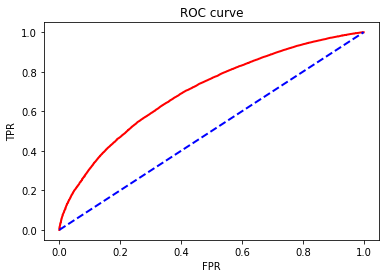

In [189]:
plot_roc(model, x_test, y_test)

In [190]:
show_scores(model, x_test, y_test)

Recall: 1.00
Precision score: 0.78
Accuracy score: 0.78


In [191]:
best_model_params = params.copy()
best_model = CatBoostClassifier(**best_model_params)
best_model.fit(train_pool, eval_set=validate_pool);

0:	test: 0.5000000	best: 0.5000000 (0)	total: 66.9ms	remaining: 26.7s
1:	test: 0.6471153	best: 0.6471153 (1)	total: 309ms	remaining: 1m 1s
2:	test: 0.6794989	best: 0.6794989 (2)	total: 560ms	remaining: 1m 14s
3:	test: 0.6881944	best: 0.6881944 (3)	total: 812ms	remaining: 1m 20s
4:	test: 0.6922573	best: 0.6922573 (4)	total: 1.06s	remaining: 1m 23s
5:	test: 0.6922573	best: 0.6922573 (4)	total: 1.13s	remaining: 1m 13s
6:	test: 0.6934423	best: 0.6934423 (6)	total: 1.35s	remaining: 1m 16s
7:	test: 0.6934423	best: 0.6934423 (6)	total: 1.42s	remaining: 1m 9s
8:	test: 0.6934423	best: 0.6934423 (6)	total: 1.48s	remaining: 1m 4s
9:	test: 0.6952976	best: 0.6952976 (9)	total: 1.73s	remaining: 1m 7s
10:	test: 0.6952976	best: 0.6952976 (9)	total: 1.79s	remaining: 1m 3s
11:	test: 0.6952976	best: 0.6952976 (9)	total: 1.86s	remaining: 1m
12:	test: 0.6952976	best: 0.6952976 (9)	total: 1.92s	remaining: 57.3s
13:	test: 0.6952976	best: 0.6952976 (9)	total: 1.99s	remaining: 54.7s
14:	test: 0.6952976	best: 0

116:	test: 0.7044309	best: 0.7044787 (100)	total: 17.5s	remaining: 42.3s
117:	test: 0.7044309	best: 0.7044787 (100)	total: 17.5s	remaining: 41.9s
118:	test: 0.7044309	best: 0.7044787 (100)	total: 17.6s	remaining: 41.5s
119:	test: 0.7044309	best: 0.7044787 (100)	total: 17.6s	remaining: 41.2s
120:	test: 0.7044309	best: 0.7044787 (100)	total: 17.7s	remaining: 40.8s
121:	test: 0.7044309	best: 0.7044787 (100)	total: 17.8s	remaining: 40.5s
122:	test: 0.7044309	best: 0.7044787 (100)	total: 17.8s	remaining: 40.1s
123:	test: 0.7045848	best: 0.7045848 (123)	total: 18s	remaining: 40.2s
124:	test: 0.7045728	best: 0.7045848 (123)	total: 18.3s	remaining: 40.3s
125:	test: 0.7045728	best: 0.7045848 (123)	total: 18.4s	remaining: 39.9s
126:	test: 0.7045728	best: 0.7045848 (123)	total: 18.4s	remaining: 39.6s
127:	test: 0.7045592	best: 0.7045848 (123)	total: 18.7s	remaining: 39.7s
128:	test: 0.7046933	best: 0.7046933 (128)	total: 18.9s	remaining: 39.7s
129:	test: 0.7046933	best: 0.7046933 (128)	total: 19s

In [192]:
feature_importances = best_model.get_feature_importance(train_pool)
feature_names = x_train.columns
top = []
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    top.append(name)
    print('{}: {}'.format(name, score))

int_rate: 21.504196038063213
dti: 10.605154625081251
annual_inc: 10.371280993921673
term: 6.695732825877977
revol_util: 6.676160400542775
total_rev_hi_lim: 6.387607419290431
installment: 6.0609233086618195
revol_bal: 6.029617865607967
total_acc: 5.675356437658795
tot_cur_bal: 5.546080977803312
open_acc: 4.277378818312348
inq_last_6mths: 4.15021065474063
loan_amnt: 2.923083640417321
initial_list_status: 1.853440974575323
tot_coll_amt: 1.243775019445164
verification_status: 0.0
sub_grade: 0.0
purpose: 0.0
home_ownership: 0.0


## LightGBM

In [193]:
import lightgbm as lgb

In [194]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
categorical_columns = x.columns[x.dtypes == 'object']
categorical_columns

Index(['verification_status', 'initial_list_status', 'term', 'purpose',
       'sub_grade', 'home_ownership'],
      dtype='object')

In [154]:
x_train['purpose'].value_counts()

debt_consolidation    82494
credit_card           27517
home_improvement       8322
other                  7876
major_purchase         3443
small_business         2665
car                    1964
medical                1589
moving                 1163
wedding                1028
house                   895
vacation                856
educational             182
renewable_energy        138
Name: purpose, dtype: int64

In [140]:
x_train['initial_list_status'] = x_train['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_train['application_type'] = x_train['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
x_test['initial_list_status'] = x_test['initial_list_status'].astype('str').map({'f': bool(1), 'w': bool(0)}) # Label encoder
x_test['application_type'] = x_test['application_type'].astype('str').map(lambda x: bool(1) if x == 'INDIVIDUAL' else bool(0))
categorical_columns = x.columns[x.dtypes == 'object']


<class 'pandas.core.frame.DataFrame'>
Int64Index: 140132 entries, 193136 to 121958
Data columns (total 19 columns):
annual_inc                    140132 non-null float64
int_rate                      140132 non-null float64
collections_12_mths_ex_med    140132 non-null float64
initial_list_status           140132 non-null bool
installment                   140132 non-null float64
open_acc                      140132 non-null float64
total_acc                     140132 non-null float64
dti                           140132 non-null float64
purpose                       140132 non-null object
grade                         140132 non-null object
home_ownership                140132 non-null object
inq_last_6mths                140132 non-null float64
pub_rec                       140132 non-null float64
revol_bal                     140132 non-null float64
revol_util                    140132 non-null float64
tot_coll_amt                  140132 non-null float64
loan_amnt                 

In [127]:
params = {
    'boosting_type': 'dart',
    'objective': 'binary',
    'metric': {'auc'},
    'num_leaves': 20,
    'max_depth' : 6,
    'max_bin':100,
    'learning_rate':  0.35,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l1' : 32,
    'verbose': 0}

In [128]:
params

{'boosting_type': 'dart',
 'objective': 'binary',
 'metric': {'auc'},
 'num_leaves': 20,
 'max_depth': 6,
 'max_bin': 100,
 'learning_rate': 0.35,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.8,
 'bagging_freq': 5,
 'lambda_l1': 32,
 'verbose': 0}

In [129]:
x_train.head()

,acc_now_delinq,annual_inc,application_type,collections_12_mths_ex_med,dti,grade_A,grade_B,grade_C,grade_D,grade_E,...,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,revol_bal,revol_util,tot_coll_amt,total_acc
193136,0.0,75000.0,True,0.0,26.85,0,1,0,0,0,...,0,0,0,0,0,0,38230.0,87.7,0.0,42.0
27784,0.0,73000.0,True,0.0,16.47,0,0,0,1,0,...,0,0,0,0,0,0,9874.0,41.0,0.0,38.0
157132,0.0,200000.0,True,0.0,13.50,1,0,0,0,0,...,0,0,0,0,0,0,34550.0,63.0,0.0,37.0
81962,0.0,100000.0,True,0.0,20.48,0,0,0,1,0,...,0,0,0,0,0,0,88599.0,60.9,0.0,36.0
161,0.0,65000.0,True,0.0,14.00,0,0,1,0,0,...,0,0,0,0,0,0,10948.0,43.6,0.0,19.0


In [130]:
lgb_train = lgb.Dataset(x_train, y_train, free_raw_data=False)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train, free_raw_data=False)

In [131]:
evals_result = {}

In [132]:
num_train, num_feature = x_train.shape
feature_name = ['feature_' + str(col) for col in range(num_feature)]

In [133]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=4000,
                valid_sets=[lgb_train, lgb_eval],
               # feature_name=feature_name,              
              #  categorical_feature= categorical_features_indices,
             #   learning_rates=lambda iter: 0.05 * (0.99 ** iter),
                evals_result=evals_result,
                verbose_eval=100)

[100]	training's auc: 0.720699	valid_1's auc: 0.708299
[200]	training's auc: 0.726036	valid_1's auc: 0.709584
[300]	training's auc: 0.730732	valid_1's auc: 0.710076
[400]	training's auc: 0.734714	valid_1's auc: 0.71066
[500]	training's auc: 0.738471	valid_1's auc: 0.710405
[600]	training's auc: 0.739775	valid_1's auc: 0.710752
[700]	training's auc: 0.742352	valid_1's auc: 0.711178
[800]	training's auc: 0.744439	valid_1's auc: 0.710858
[900]	training's auc: 0.746693	valid_1's auc: 0.710874
[1000]	training's auc: 0.748546	valid_1's auc: 0.710658
[1100]	training's auc: 0.750315	valid_1's auc: 0.709928
[1200]	training's auc: 0.751638	valid_1's auc: 0.709708
[1300]	training's auc: 0.75301	valid_1's auc: 0.709218
[1400]	training's auc: 0.755273	valid_1's auc: 0.708481
[1500]	training's auc: 0.756091	valid_1's auc: 0.708636
[1600]	training's auc: 0.757775	valid_1's auc: 0.708289
[1700]	training's auc: 0.759684	valid_1's auc: 0.708028
[1800]	training's auc: 0.761302	valid_1's auc: 0.707554
[19

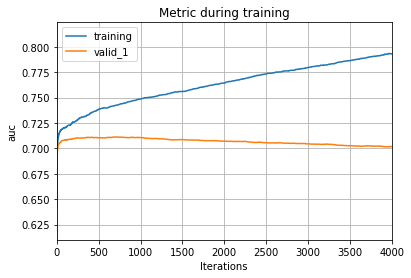

In [134]:
lgb.plot_metric(evals_result, metric='auc')
plt.show()